In [1]:
# activate autoreload
%load_ext autoreload
%autoreload 2

# check if session is in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print('Google Colab session!')
except:
    IN_COLAB = False
    print('Not a Google Colab session.')

# add src path to the notebook
import os
import sys
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT: str = '/content/drive/MyDrive/papers/2025b_relevance_2.0'
    !pip install contextily esda deep-translator h3pandas h3~=3.0 datasets optuna setfit
else:
    PROJECT_ROOT: str = os.path.dirname(os.path.abspath(os.path.dirname("__file__")))
if PROJECT_ROOT not in sys.path:
    sys.path.append(os.path.join(PROJECT_ROOT))
print(PROJECT_ROOT)

Not a Google Colab session.
/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_Relevance_Classification


# Visualisation
In this notebook, we visualise the results of our spatially enhanced relevance classification paper.

In [10]:
import warnings
import shap
import pickle
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from transformers import pipeline
from scipy.stats import kruskal, pearsonr
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from src.utils import get_group_metrics, get_class_metrics, top_k_lang_distribution, detect_language_fast
from src.model_training.classification_head import optimise_model
from src.model_training.bert import extract_probabilities


# set data path
DATA_PATH: str = os.path.join(PROJECT_ROOT, 'data')
RESULTS_PATH: str = os.path.join(PROJECT_ROOT, 'results')
print(DATA_PATH)

# Set up plotting style
sns.set_style("whitegrid", {'grid.color': '#EAEAEA', 'grid.linestyle': '--'})
plt.rcParams["font.family"] = "sans-serif"

# Define an Economist-like colour palette for the classes
class_palette = {
    "Not related": "#4C72B0",            # Deep Navy Blue
    "Related but not relevant": "#6E6E6E", # Muted Gray
    "Related and relevant": "#C8102E"      # Economist Red
}

model_palette = {
    "Text-only": "#2E2E2E",        # Charcoal Gray
    "Non-text": "#8E8E8E",         # Light Slate Gray
    "Text + non-text": "#C8102E"    # Economist Red
}
model_palette_v2 = {
    "Text-only": "#4C72B0",        # Charcoal Gray
    "Non-text": "#6E6E6E",         # Light Slate Gray
    "Text + non-text": "#C8102E"    # Economist Red
}


# Define an Economist-style diverging colormap:
# economist_cmap = LinearSegmentedColormap.from_list("economist", ["#4C72B0", "#F7F7F7", "#C8102E"])

# Define coherent labels
use_case_labels: dict = {'California 🔥': 'California wildfires', 
                    'Chile 🔥': 'Chile wildfires', 
                    'Germany 🌊': 'Ahr Valley floods',
                    'Italy 🌊': 'Emilia-Romagna floods',
                    'Turkey 🪨': 'Turkey earthquake'}
non_text_labels: dict = {
    'event_distance_km': 'Geographic distance (km)',
    'event_distance_h': 'Temporal distance (h)',
    'n_disaster_tweets_1km': 'Number of disaster posts (1km)',
    'n_disaster_tweets_5km': 'Number of disaster posts (5km)',
    'n_disaster_tweets_10km': 'Number of disaster posts (10km)',
    'n_disaster_tweets_50km': 'Number of disaster posts (50km)',
    'n_disaster_tweets_10000km': 'Number of disaster posts (AOI)',
    'event_distance_km_norm': 'Geographic distance (km)',
    'event_distance_h_norm': 'Temporal distance (h)',
    'n_disaster_tweets_1km_norm': 'Number of disaster posts (1km)',
    'n_disaster_tweets_10km_norm': 'Number of disaster posts (10km)',
    'n_disaster_tweets_50km_norm': 'Number of disaster posts (50km)',
    'n_disaster_tweets_10000km_norm': 'Number of disaster posts (AOI)',
    'int_label': 'Relevance',
    'wildfire': 'Wildfire (0/1)',
    'flood': 'Flood (0/1)',
    'earthquake': 'Earthquake (0/1)',
    'sphere_x': 'x (sphere)',
    'sphere_y': 'y (sphere)',
    'sphere_z': 'z (sphere)',
    'p_not_related': r'$P_{\text{text}}(\text{Not related})$',
    'p_related_but_not_relevant': r'$P_{\text{text}}(\text{Related but not relevant})$',
    'p_related_and_relevant': r'$P_{\text{text}}(\text{Related and relevant})$'
}

class_mappings: dict = {
    0: 'Not related',
    1: 'Related but not relevant',
    2: 'Related and relevant'
}

NON_TEXT_COLUMNS: list[str] = ['event_distance_km', 'event_distance_h', 'n_disaster_tweets_1km',
                               'n_disaster_tweets_10km', 'n_disaster_tweets_50km', 'n_disaster_tweets_10000km']
NON_TEXT_COLUMNS_EXTENDED: list[str] = ['event_distance_km', 'event_distance_h', 'n_disaster_tweets_1km', 'n_disaster_tweets_5km',
                               'n_disaster_tweets_10km', 'n_disaster_tweets_50km', 'n_disaster_tweets_10000km']
NON_TEXT_COLUMNS_NORM: list[str] = [f'{col}_norm' for col in NON_TEXT_COLUMNS]
LABEL_COLUMN: str = 'human_label_100km'

/mnt/c/Users/DavidHanny/OneDrive - IT U interdisciplinary transformation university austria/Documents/projects/papers/2025_GSAI_RES_Relevance_Classification/data


## 1. Feature Engineering
We start off by looking at our engineered non-text features in more detail.

In [6]:
relevance_tweets: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'relevance_tweets_w_features.parquet')
)
print(relevance_tweets.shape)
print(relevance_tweets.groupby(LABEL_COLUMN).size())
print(relevance_tweets.groupby('use_case').size())
pd.DataFrame(relevance_tweets)

(4574, 38)
human_label_100km
Not related                 1646
Related and relevant         993
Related but not relevant    1935
dtype: int64
use_case
California 🔥    1040
Chile 🔥          924
Germany 🌊       1026
Italy 🌊          542
Turkey 🪨        1042
dtype: int64


,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,emotion_probs,sentiment_probs,event_encoding,event_type_encoding,lon_centre,lat_centre,sphere_x,sphere_y,sphere_z,int_label
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,es,POINT (-68.32775 -34.61872),None,@sanchezzdiegoo Quíhuboo,0,-7606507.783,...,"[0.1116873100399971, 0.08837432414293289, 0.76...","[0.24736149609088898, 0.2910509407520294, 0.46...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86406 -32.88166),None,Cómo extraño ir a la aristides a ver los parti...,0,-7666204.585,...,"[0.0013001792831346393, 0.0009399839327670634,...","[0.7456169724464417, 0.16595792770385742, 0.08...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39489 -35.96467),None,Es un robo de agua pohhhhhhh,1,-7947942.472,...,"[0.011820702813565731, 0.006169864907860756, 0...","[0.01800038106739521, 0.11428425461053848, 0.8...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63593 -33.36501),None,@anakarinagcm Temazo ese,0,-7863444.522,...,"[0.7321125268936157, 0.24522025883197784, 0.00...","[0.4914751648902893, 0.4647566080093384, 0.043...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77574 -28.46427),None,La primer grieta del 2023 en Catamarca está en...,1,-7322394.226,...,"[0.003971186000853777, 0.9815961718559265, 0.0...","[0.773543119430542, 0.2026240974664688, 0.0238...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,1.624750e+18,2023-02-12 12:41:16,Turkey 🪨,Malatya Belediye binasında HAYTAP ve Gönüllüle...,tr,POINT (38.42179 38.33319),None,Malatya Belediye binasında HAYTAP ve Gönüllüle...,1,4277176.141,...,None,None,"[0, 0, 0, 0, 1]","[0, 0, 1]",35.317673,38.790595,-0.334224,-0.317761,0.887312,2
4742,1.622680e+18,2023-02-06 19:49:24,Turkey 🪨,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,tr,POINT (32.50940 37.86591),None,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,1,3619077.241,...,None,None,"[0, 0, 0, 0, 1]","[0, 0, 1]",35.317673,38.790595,-0.334224,-0.317761,0.887312,1
4743,1.622570e+18,2023-02-06 12:12:59,Turkey 🪨,@user Akademisyen Yusuf Buğra DOĞAN hocaya ula...,tr,POINT (32.74337 39.96367),None,@KadinveCocuk_ Akademisyen Yusuf Buğra DOĞAN h...,1,3645125.223,...,None,None,"[0, 0, 0, 0, 1]","[0, 0, 1]",35.317673,38.790595,-0.334224,-0.317761,0.887312,1
4744,1.623030e+18,2023-02-07 19:04:25,Turkey 🪨,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,tr,POINT (32.84059 39.99656),None,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,1,3655947.704,...,None,None,"[0, 0, 0, 0, 1]","[0, 0, 1]",35.317673,38.790595,-0.334224,-0.317761,0.887312,1


In [4]:
# Initialise a list to collect results
kruskal_dictlist: list[dict] = []

# Group the data by use_case
for use_case, group in relevance_tweets.groupby('use_case'):
    # Loop over each non-text column
    for col in NON_TEXT_COLUMNS:
        # For each class in this use_case, extract the column data (dropping NA values)
        class_groups = [subgroup[col].dropna() 
                        for _, subgroup in group.groupby(LABEL_COLUMN)]
        
        # Ensure there are exactly 3 groups to compare; if not, assign np.nan
        if len(class_groups) == 3:
            # Compute the mean for each class
            group_means: list[float] = [g.mean() for g in class_groups]
            # Calculate the pairwise absolute differences between the means
            pair_diffs: float = [abs(x - y) for x, y in itertools.combinations(group_means, 2)]
            # Compute the average difference between all pairs
            avg_pair_diff: float = np.mean(pair_diffs)
            # Perform the Kruskal-Wallis test and extract the p-value
            _, p_value = kruskal(*class_groups)
        else:
            p_value: float = np.nan
            avg_pair_diff: float = np.nan
            
        # Append the result as a dictionary
        kruskal_dictlist.append({
            'use_case': use_case,
            'column': col,
            'p_value': p_value,
            'avg_diff_means': avg_pair_diff
        })

# Convert the list of results into a dataframe
kruskal_results: pd.DataFrame = pd.DataFrame(kruskal_dictlist)
kruskal_results.to_csv(os.path.join(RESULTS_PATH, 'feature_engineering', 'kruskal_results.csv'), index=False)
kruskal_results

,use_case,column,p_value,avg_diff_means
0,California 🔥,event_distance_km,8.505729e-02,0.809189
1,California 🔥,event_distance_h,4.804805e-02,5.380730
2,California 🔥,n_disaster_tweets_1km,1.122264e-63,5.467593
3,California 🔥,n_disaster_tweets_10km,5.806798e-69,8.966795
4,California 🔥,n_disaster_tweets_50km,6.884985e-77,44.781219
5,California 🔥,n_disaster_tweets_10000km,3.555943e-100,279.340591
6,Chile 🔥,event_distance_km,4.387908e-28,36.760496
7,Chile 🔥,event_distance_h,5.613903e-01,4.745916
8,Chile 🔥,n_disaster_tweets_1km,1.203808e-26,6.281478
9,Chile 🔥,n_disaster_tweets_10km,9.199308e-56,30.508496


For which column is the p value not significant?

In [5]:
kruskal_results[kruskal_results['p_value'] > 0.05]

,use_case,column,p_value,avg_diff_means
0,California 🔥,event_distance_km,0.085057,0.809189
7,Chile 🔥,event_distance_h,0.561390,4.745916


To get a better overview, we can also try to plot the average values per class across use cases.

In [6]:
relevance_tweets.groupby(['use_case', LABEL_COLUMN])[NON_TEXT_COLUMNS].mean().reset_index()

,use_case,human_label_100km,event_distance_km,event_distance_h,n_disaster_tweets_1km,n_disaster_tweets_10km,n_disaster_tweets_50km,n_disaster_tweets_10000km
0,California 🔥,Not related,6.449601,2.359022,3.354167,4.763021,19.239583,112.208333
1,California 🔥,Related and relevant,6.878743,9.527098,9.393189,15.291022,80.743034,522.405573
2,California 🔥,Related but not relevant,5.664959,10.430118,11.555556,18.213213,86.411411,531.219219
3,Chile 🔥,Not related,63.320634,3.506130,3.209068,12.687657,31.697733,319.098237
4,Chile 🔥,Related and relevant,8.179891,-3.314187,2.915584,43.883117,118.051948,1044.331169
5,Chile 🔥,Related but not relevant,16.733423,-3.612744,12.337802,58.450402,154.630027,1125.126005
6,Germany 🌊,Not related,62.360208,42.556875,4.599424,6.363112,23.034582,228.288184
7,Germany 🌊,Related and relevant,8.261740,27.620110,9.488506,27.235632,253.614943,1184.839080
8,Germany 🌊,Related but not relevant,190.728355,28.959413,15.914851,25.130693,116.348515,1438.772277
9,Italy 🌊,Not related,29.369531,52.229216,1.190955,1.628141,13.894472,72.708543


In [7]:
print(relevance_tweets.groupby(['use_case', LABEL_COLUMN])[NON_TEXT_COLUMNS].mean().reset_index().to_latex())

\begin{tabular}{lllrrrrrr}
\toprule
 & use_case & human_label_100km & event_distance_km & event_distance_h & n_disaster_tweets_1km & n_disaster_tweets_10km & n_disaster_tweets_50km & n_disaster_tweets_10000km \\
\midrule
0 & California 🔥 & Not related & 6.449601 & 2.359022 & 3.354167 & 4.763021 & 19.239583 & 112.208333 \\
1 & California 🔥 & Related and relevant & 6.878743 & 9.527098 & 9.393189 & 15.291022 & 80.743034 & 522.405573 \\
2 & California 🔥 & Related but not relevant & 5.664959 & 10.430118 & 11.555556 & 18.213213 & 86.411411 & 531.219219 \\
3 & Chile 🔥 & Not related & 63.320634 & 3.506130 & 3.209068 & 12.687657 & 31.697733 & 319.098237 \\
4 & Chile 🔥 & Related and relevant & 8.179891 & -3.314187 & 2.915584 & 43.883117 & 118.051948 & 1044.331169 \\
5 & Chile 🔥 & Related but not relevant & 16.733423 & -3.612744 & 12.337802 & 58.450402 & 154.630027 & 1125.126005 \\
6 & Germany 🌊 & Not related & 62.360208 & 42.556875 & 4.599424 & 6.363112 & 23.034582 & 228.288184 \\
7 & Germany 🌊 

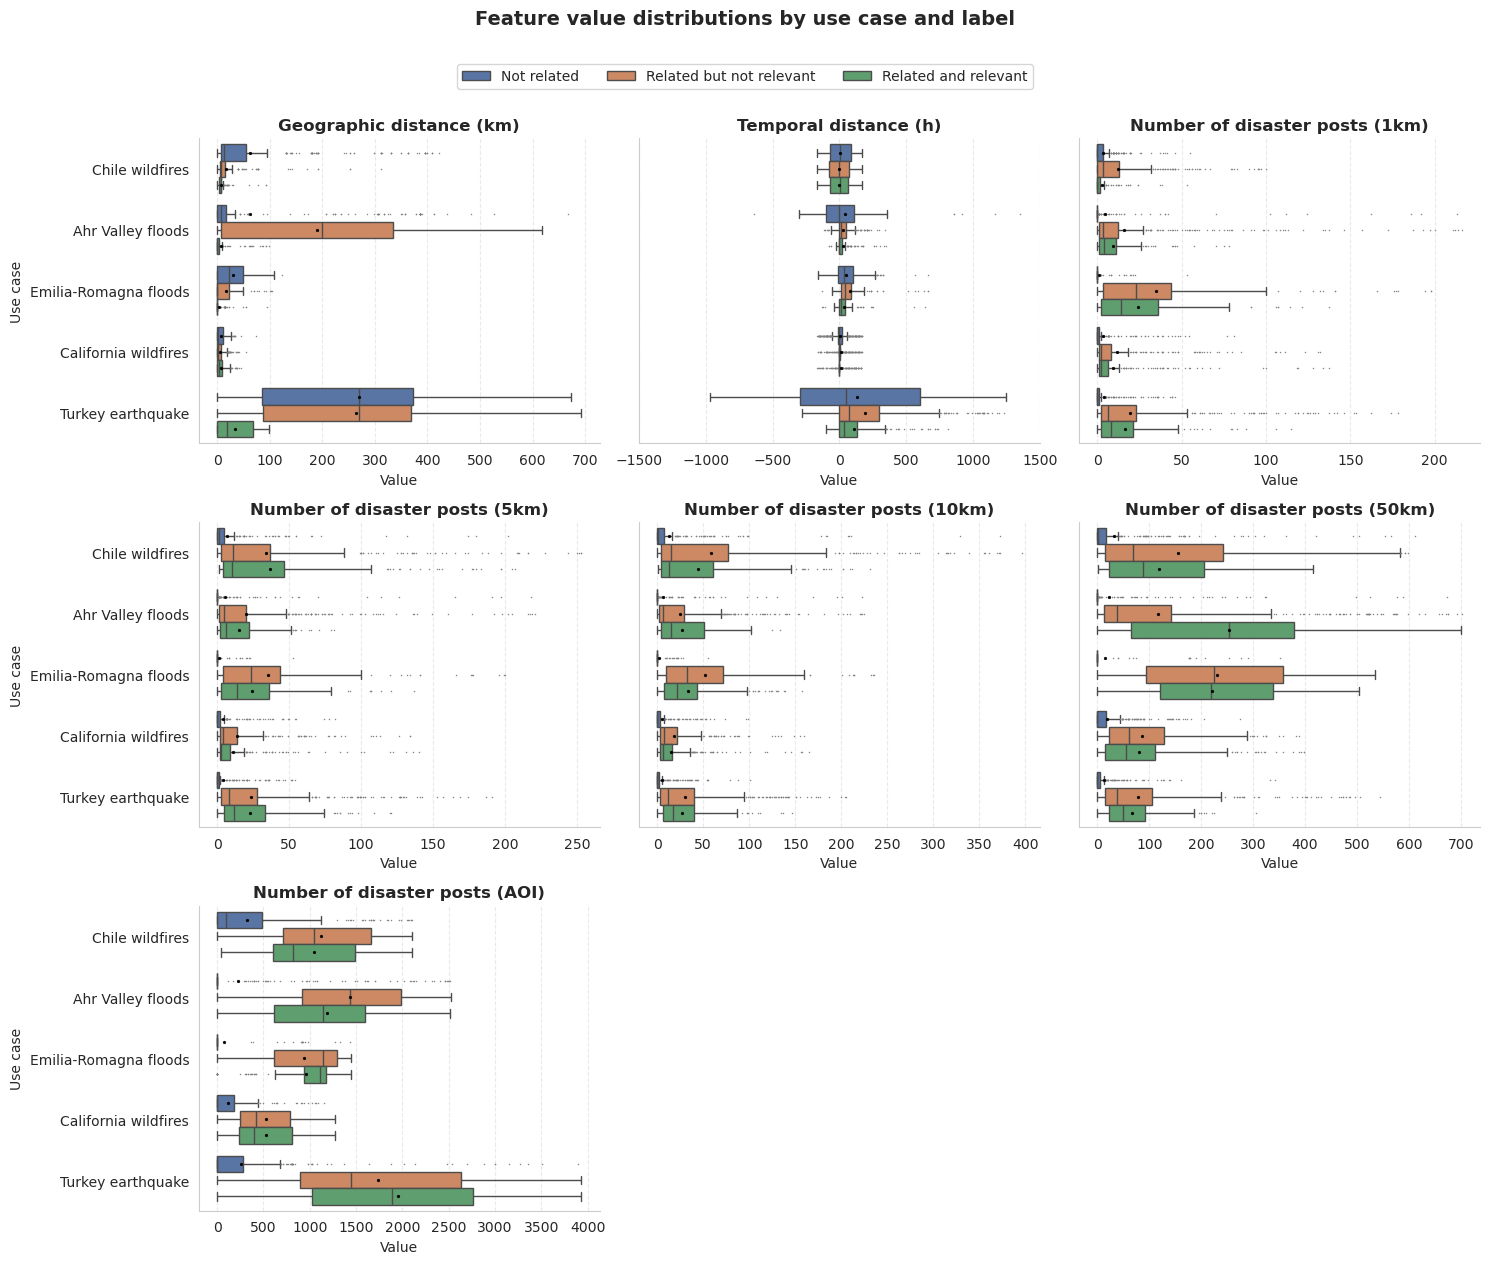

In [17]:
# Prepare the raw data for plotting
box_df = relevance_tweets.copy()
box_df['use_case_label'] = box_df['use_case'].map(use_case_labels)

# Melt the dataframe to long format so each row corresponds to one feature value
box_df = box_df.melt(
    id_vars=['use_case', LABEL_COLUMN, 'use_case_label'],
    value_vars=NON_TEXT_COLUMNS_EXTENDED,
    var_name='feature',
    value_name='value'
)

# Map feature names for readability
box_df['feature'] = box_df['feature'].map(non_text_labels)

# Define the desired order for human labels
human_order = ["Not related", "Related but not relevant", "Related and relevant"]
box_df[LABEL_COLUMN] = pd.Categorical(box_df[LABEL_COLUMN], categories=human_order, ordered=True)

# Get unique features and determine layout for subplots
features = box_df['feature'].unique()
n_features = len(features)
cols = 3
rows = int(np.ceil(n_features / cols))

# Create the subplots with shared y-axis (use cases on the left)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharey=True)
axes = axes.flatten()

# Loop over each feature and create a horizontal boxplot with Economist style
for i, feature in enumerate(features):
    ax = axes[i]
    feature_df = box_df[box_df['feature'] == feature]
    sns.boxplot(
        data=feature_df,
        y='use_case_label',
        x='value',
        hue=LABEL_COLUMN,
        ax=ax,
        # palette=class_palette,
        palette='deep',
        # boxprops={"edgecolor": "k", "linewidth": 0.5},
        showfliers=True,
        flierprops={'marker':'o','markerfacecolor':'gray','markeredgecolor':'gray','markersize':'0.75', 'markeredgewidth': '0.3'},
        showmeans=True,
        meanprops={'marker':'o','markerfacecolor':'k','markeredgecolor':'k','markersize':'2', 'markeredgewidth': '0.3'}
    )
    if feature == "Temporal distance (h)":
        ax.set_xlim(-1500, 1500)
    ax.set_title(feature, fontsize=12, fontweight='bold')
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Use case', fontsize=10)
    # Remove subplot-specific legends (we will add one global legend later)
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    sns.despine(ax=ax, trim=False)
    ax.tick_params(axis='both', which='major', labelsize=10)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Create a single global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.01))
fig.suptitle('Feature value distributions by use case and label', y=1.05, fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(RESULTS_PATH, 'feature_engineering', 'boxplot_feature_values.pdf'), dpi=300, bbox_inches='tight')

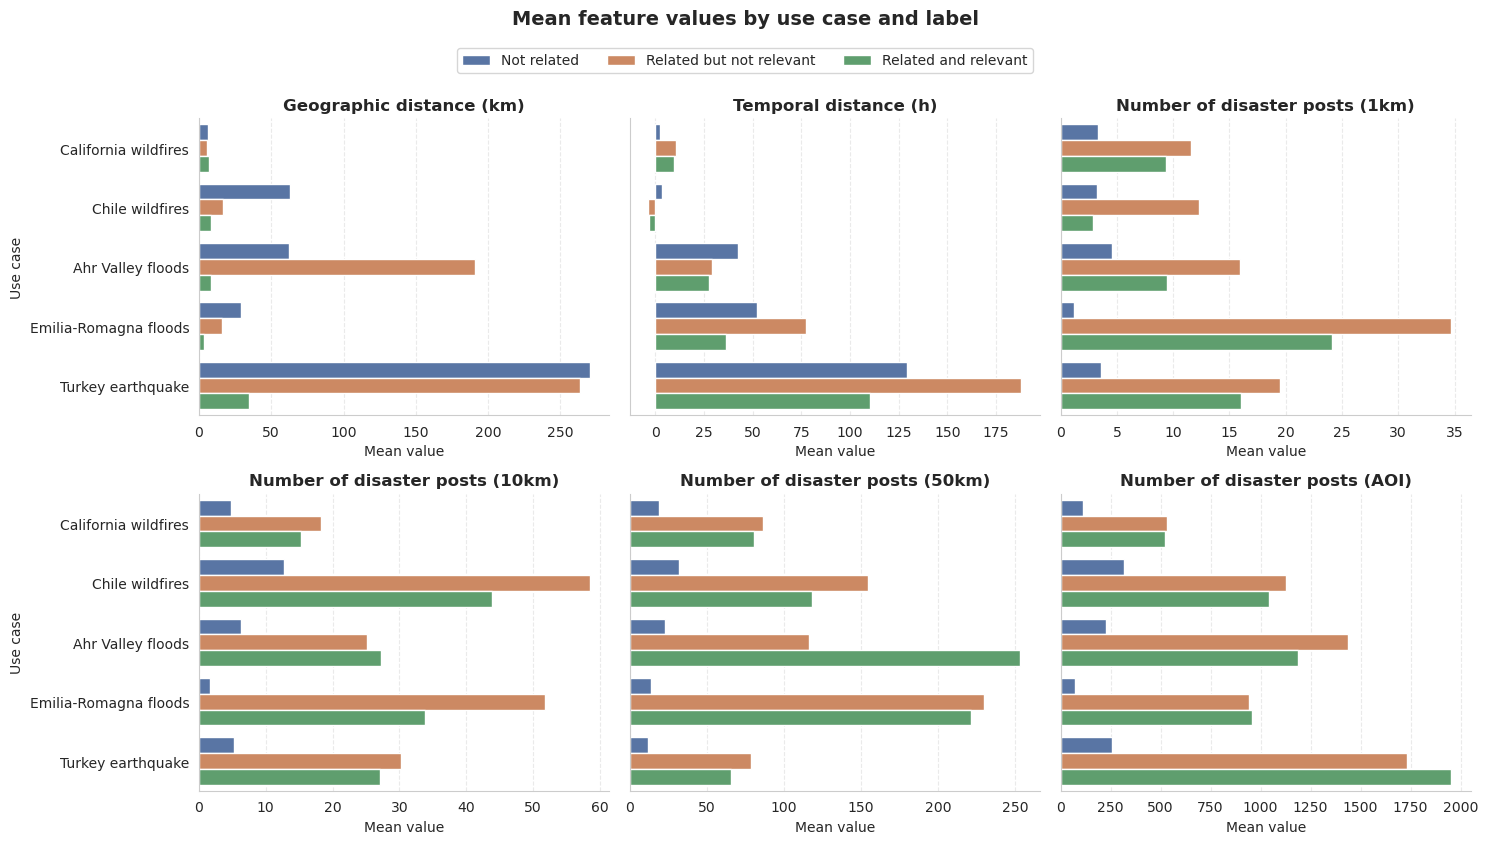

In [9]:
mean_df: pd.DataFrame = (relevance_tweets.groupby(['use_case', LABEL_COLUMN])[NON_TEXT_COLUMNS]
                         .mean()
                         .reset_index()
                         .melt(id_vars=['use_case', LABEL_COLUMN], var_name='feature', value_name='mean_value'))

mean_df['use_case_label'] = mean_df['use_case'].map(use_case_labels)
mean_df['feature'] = mean_df['feature'].map(non_text_labels)

# Define the desired order for human labels
human_order = ["Not related", "Related but not relevant", "Related and relevant"]
mean_df[LABEL_COLUMN] = pd.Categorical(mean_df[LABEL_COLUMN], categories=human_order, ordered=True)

# Get unique features and determine layout
features = mean_df['feature'].unique()
n_features = len(features)
cols = 3
rows = int(np.ceil(n_features / cols))

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharey=True)
axes = axes.flatten()

# Loop over each feature and create a horizontal bar plot
for i, feature in enumerate(features):
    ax = axes[i]
    feature_df = mean_df[mean_df['feature'] == feature]
    # Use horizontal bar plot so that use cases appear on the left
    sns.barplot(
        data=feature_df, 
        y='use_case_label',
        x='mean_value',
        hue=LABEL_COLUMN, ax=ax, 
        # palette=class_palette
        palette='deep',
    )  # alternative use deep
    ax.set_title(feature, fontsize=12, fontweight='bold')
    ax.set_xlabel('Mean value', fontsize=10)
    ax.set_ylabel('Use case', fontsize=10)
    # Remove legend from each subplot (we'll add one global legend later)
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    sns.despine(ax=ax, trim=False)
    # ax.grid(axis='x')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Get the legend handles and labels from one of the plots (they are the same across subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.01))
fig.suptitle('Mean feature values by use case and label', y=1.05, fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(RESULTS_PATH, 'feature_engineering', 'mean_feature_values.pdf'), dpi=300, bbox_inches='tight')

Lastly, we can compute a correlation matrix for our features.

In [15]:
correlation_dictlist: list[dict] = []
columns: list[str] = NON_TEXT_COLUMNS_EXTENDED + ['int_label']
for col_i in columns:
    corr_row: dict = {'row': col_i}
    for col_j in columns:
        if col_i == col_j:
            corr_row[col_j] = 1.0
        else:
            corr, p = pearsonr(relevance_tweets[col_i], relevance_tweets[col_j])
            if p < 0.05:
                corr_row[col_j] = corr
            else:
                corr_row[col_j] = np.nan
    correlation_dictlist.append(corr_row)

correlation_df: pd.DataFrame = pd.DataFrame(correlation_dictlist)
correlation_df['row'] = correlation_df['row'].map(non_text_labels)
correlation_df = correlation_df.set_index('row')
correlation_df.columns = correlation_df.columns.map(non_text_labels)
correlation_df

,Geographic distance (km),Temporal distance (h),Number of disaster posts (1km),Number of disaster posts (5km),Number of disaster posts (10km),Number of disaster posts (50km),Number of disaster posts (AOI),Relevance
row,,,,,,,,
Geographic distance (km),1.000000,0.115924,0.125988,0.054367,NaN,-0.146661,0.205168,-0.140204
Temporal distance (h),0.115924,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Number of disaster posts (1km),0.125988,NaN,1.000000,0.794947,0.686921,0.443012,0.379591,0.164329
Number of disaster posts (5km),0.054367,NaN,0.794947,1.000000,0.886752,0.534383,0.417435,0.206955
Number of disaster posts (10km),NaN,NaN,0.686921,0.886752,1.000000,0.659665,0.410551,0.204728
Number of disaster posts (50km),-0.146661,NaN,0.443012,0.534383,0.659665,1.000000,0.461999,0.355401
Number of disaster posts (AOI),0.205168,NaN,0.379591,0.417435,0.410551,0.461999,1.000000,0.420119
Relevance,-0.140204,NaN,0.164329,0.206955,0.204728,0.355401,0.420119,1.000000


Ideally, we also investigate the correlation of our features.

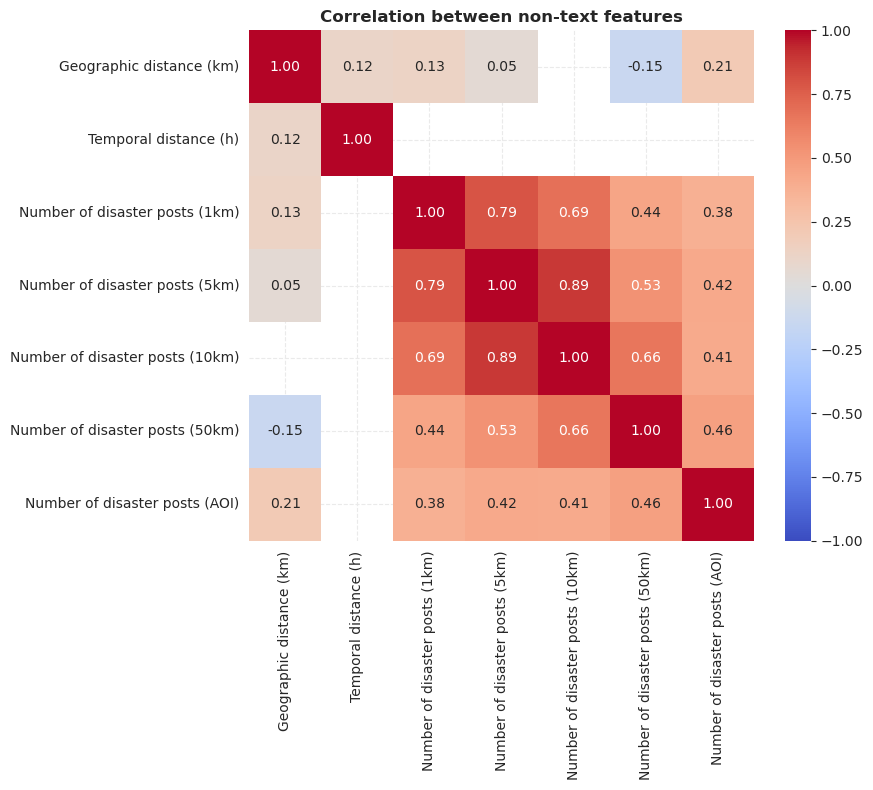

In [16]:
fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(correlation_df.iloc[:-1, :-1], annot=True, fmt=".2f", vmin=-1, vmax=1, ax=ax, cmap='coolwarm')# , cmap=economist_cmap,)
ax.set_title('Correlation between non-text features', fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('')
fig.tight_layout()
fig.savefig(os.path.join(RESULTS_PATH, 'feature_engineering', 'feature_correlation.pdf'), dpi=300,  bbox_inches='tight')

And plot a barplot regarding the correlation of features with relevance.

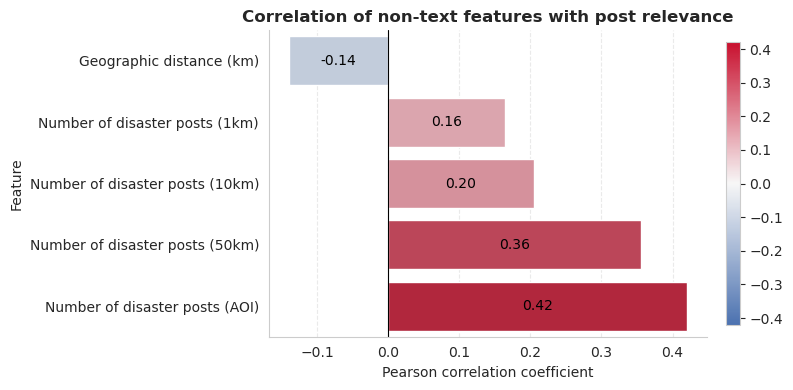

In [34]:
# Prepare the sorted dataframe
df_sorted: pd.DataFrame = correlation_df.dropna(subset='Relevance').iloc[:-1, -1].sort_values().reset_index().rename(
    columns={'row': 'Feature', 'Relevance': 'Correlation with relevance'}
)

# Compute the maximum absolute correlation from the data (you can also fix this value, e.g., 0.45)
max_abs = max(abs(df_sorted["Correlation with relevance"].min()), abs(df_sorted["Correlation with relevance"].max()))

# Normalize each value so that 0 maps to 0.5, the most negative maps to 0 and the most positive to 1.
colors = [economist_cmap(0.5 + val/(2*max_abs)) for val in df_sorted["Correlation with relevance"]]

fig, ax = plt.subplots(figsize=(8, 4))
# Use the computed colors directly in the palette; remove hue so that we apply our custom colors.
ax = sns.barplot(data=df_sorted, x='Correlation with relevance', y='Feature', hue='Correlation with relevance',
                 palette=colors, legend=False)

# Draw a vertical line at 0 for reference
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Pearson correlation coefficient', fontsize=10)
ax.set_ylabel('Feature', fontsize=10)
ax.set_title('Correlation of non-text features with post relevance', fontsize=12, fontweight='bold')

# Add value labels with dark text for contrast
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', color='k', fontsize=10)

# Create a colorbar based on the Economist colormap
norm = mpl.colors.Normalize(vmin=-max_abs, vmax=max_abs)
sm = mpl.cm.ScalarMappable(cmap=economist_cmap, norm=norm)
sm.set_array([])  # Only needed for older mpl versions
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
# cbar.set_label('Correlation with relevance', fontsize=12)

sns.despine(ax=ax)
fig.tight_layout()
fig.savefig(os.path.join(RESULTS_PATH, 'feature_engineering', 'relevance_correlation.pdf'),
            dpi=300, bbox_inches='tight')

## 2. Non-text Feature Classification
Let's visualise the classification metrics for our non-text models.

In [16]:
results_df: pd.DataFrame = pd.read_csv(os.path.join(RESULTS_PATH, 'non_text_model', 'evaluation_metrics_non_text.csv'))
results_df_use_case: pd.DataFrame = pd.read_csv(os.path.join(RESULTS_PATH, 'non_text_model', 'evaluation_metrics_non_text_use_case.csv'))
print(results_df.shape, results_df_use_case.shape)
results_df

(48, 12) (12, 12)


,base_features,event_encoding,model,best_params,val_macro_f1,test_macro_prec,test_macro_rec,test_macro_f1,test_acc,test_roc_auc,test_rmse,test_mae
0,regular,none,logistic_regression,"{'C': 10, 'max_iter': 1000, 'penalty': 'l2', '...",0.585663,0.648924,0.617993,0.611093,0.674317,0.857465,0.709036,0.384699
1,regular,none,random_forest,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",0.677376,0.712826,0.703078,0.706997,0.731148,0.878270,0.640184,0.315847
2,regular,none,svm,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.573389,0.649406,0.593029,0.574616,0.679781,0.854439,0.615821,0.339891
3,regular,none,gradient_boosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.675347,0.695692,0.691466,0.693344,0.719126,0.876649,0.657034,0.331148
4,regular,none,knn,"{'n_neighbors': 9, 'weights': 'distance'}",0.659864,0.679874,0.671237,0.674649,0.700546,0.855519,0.663654,0.346448
5,regular,none,naive_bayes,{'var_smoothing': 1e-09},0.550328,0.629824,0.626258,0.589971,0.612022,0.826874,0.800273,0.472131
6,regular,event_type_encoding,logistic_regression,"{'C': 0.1, 'max_iter': 2000, 'penalty': 'l2', ...",0.612572,0.674478,0.630163,0.626489,0.687432,0.858802,0.692663,0.368306
7,regular,event_type_encoding,random_forest,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.695765,0.733786,0.721535,0.726393,0.748634,0.889245,0.613153,0.292896
8,regular,event_type_encoding,svm,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.567000,0.648860,0.592215,0.572605,0.679781,0.854490,0.615821,0.339891
9,regular,event_type_encoding,gradient_boosting,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.688659,0.714870,0.712013,0.713262,0.735519,0.886994,0.636761,0.311475


In [17]:
feature_variants: pd.DataFrame = results_df.groupby('base_features')['test_macro_f1'].mean().reset_index()
print(feature_variants.to_latex(float_format="{:.3f}".format, index=False))

\begin{tabular}{lr}
\toprule
base_features & test_macro_f1 \\
\midrule
norm & 0.656 \\
regular & 0.650 \\
\bottomrule
\end{tabular}



We only visualise the results with regular features.

In [18]:
results_df = results_df[results_df['base_features'] == 'regular']
print(results_df.shape)

(24, 12)


In [21]:
results_df

,base_features,event_encoding,model,best_params,val_macro_f1,test_macro_prec,test_macro_rec,test_macro_f1,test_acc,test_roc_auc,test_rmse,test_mae
0,regular,none,logistic_regression,"{'C': 10, 'max_iter': 1000, 'penalty': 'l2', '...",0.585663,0.648924,0.617993,0.611093,0.674317,0.857465,0.709036,0.384699
1,regular,none,random_forest,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",0.677376,0.712826,0.703078,0.706997,0.731148,0.878270,0.640184,0.315847
2,regular,none,svm,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.573389,0.649406,0.593029,0.574616,0.679781,0.854439,0.615821,0.339891
3,regular,none,gradient_boosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.675347,0.695692,0.691466,0.693344,0.719126,0.876649,0.657034,0.331148
4,regular,none,knn,"{'n_neighbors': 9, 'weights': 'distance'}",0.659864,0.679874,0.671237,0.674649,0.700546,0.855519,0.663654,0.346448
5,regular,none,naive_bayes,{'var_smoothing': 1e-09},0.550328,0.629824,0.626258,0.589971,0.612022,0.826874,0.800273,0.472131
6,regular,event_type_encoding,logistic_regression,"{'C': 0.1, 'max_iter': 2000, 'penalty': 'l2', ...",0.612572,0.674478,0.630163,0.626489,0.687432,0.858802,0.692663,0.368306
7,regular,event_type_encoding,random_forest,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.695765,0.733786,0.721535,0.726393,0.748634,0.889245,0.613153,0.292896
8,regular,event_type_encoding,svm,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.567000,0.648860,0.592215,0.572605,0.679781,0.854490,0.615821,0.339891
9,regular,event_type_encoding,gradient_boosting,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.688659,0.714870,0.712013,0.713262,0.735519,0.886994,0.636761,0.311475


First of all, which configuration worked overall best?

In [20]:
event_encoding_results: pd.DataFrame = results_df.groupby('event_encoding')['test_macro_f1'].mean().reset_index()
print(event_encoding_results.to_latex(float_format="{:.3f}".format, index=False))

\begin{tabular}{lr}
\toprule
event_encoding & test_macro_f1 \\
\midrule
event_type_encoding & 0.651 \\
event_type_encoding + sphere_coords & 0.649 \\
none & 0.642 \\
sphere_coords & 0.657 \\
\bottomrule
\end{tabular}



We get and print the best configuration for each model.

In [22]:
best_idxs = results_df[results_df['event_encoding'] == 'event_type_encoding + sphere_coords'].groupby('model')['test_macro_f1'].idxmax()
best_model_results: pd.DataFrame = results_df.iloc[best_idxs][['model', 'val_macro_f1', 'test_macro_f1', 'test_acc', 'test_roc_auc', 'test_rmse']]
best_model_results.sort_values(by='model', ascending=True, inplace=True)
print(best_model_results.to_latex(float_format="{:.3f}".format, index=False))
best_model_results

\begin{tabular}{lrrrrr}
\toprule
model & val_macro_f1 & test_macro_f1 & test_acc & test_roc_auc & test_rmse \\
\midrule
gradient_boosting & 0.695 & 0.710 & 0.731 & 0.891 & 0.640 \\
knn & 0.659 & 0.675 & 0.701 & 0.857 & 0.664 \\
logistic_regression & 0.622 & 0.624 & 0.674 & 0.861 & 0.707 \\
naive_bayes & 0.562 & 0.601 & 0.622 & 0.811 & 0.777 \\
random_forest & 0.704 & 0.713 & 0.731 & 0.887 & 0.627 \\
svm & 0.566 & 0.573 & 0.681 & 0.855 & 0.615 \\
\bottomrule
\end{tabular}



,model,val_macro_f1,test_macro_f1,test_acc,test_roc_auc,test_rmse
21,gradient_boosting,0.695208,0.709786,0.731148,0.890596,0.640184
22,knn,0.659497,0.674649,0.700546,0.856804,0.663654
18,logistic_regression,0.621696,0.623767,0.674317,0.860972,0.706720
23,naive_bayes,0.561877,0.600690,0.621858,0.811249,0.777413
19,random_forest,0.704438,0.712653,0.731148,0.887238,0.627250
20,svm,0.565823,0.573291,0.680874,0.854551,0.614933


We can see that the random forest yielded the highest validation F1 while the gradient boosting model yielded the highest test F1 score. During model-building, it makes most sense to select by validation F1 score as the test data should never be used for any model selection.

Now what if we want to compare the results with per-use-case model fitting?

In [23]:
results_df_use_case = results_df_use_case[results_df_use_case['base_features'] == 'regular']
best_idxs = results_df_use_case.groupby('model')['test_macro_f1'].idxmax()
best_model_results: pd.DataFrame = results_df_use_case.iloc[best_idxs][['model', 'val_macro_f1', 'test_macro_f1', 'test_acc', 'test_roc_auc', 'test_rmse']]
best_model_results.sort_values(by='model', ascending=True, inplace=True)
print(best_model_results.to_latex(float_format="{:.3f}".format, index=False))
best_model_results

\begin{tabular}{lrrrrr}
\toprule
model & val_macro_f1 & test_macro_f1 & test_acc & test_roc_auc & test_rmse \\
\midrule
gradient_boosting & 0.717 & 0.703 & 0.723 & 0.872 & 0.651 \\
knn & 0.672 & 0.695 & 0.718 & 0.866 & 0.625 \\
logistic_regression & 0.675 & 0.648 & 0.691 & 0.857 & 0.686 \\
naive_bayes & 0.627 & 0.626 & 0.643 & 0.835 & 0.757 \\
random_forest & 0.717 & 0.702 & 0.720 & 0.882 & 0.649 \\
svm & 0.699 & 0.688 & 0.716 & 0.863 & 0.634 \\
\bottomrule
\end{tabular}



,model,val_macro_f1,test_macro_f1,test_acc,test_roc_auc,test_rmse
3,gradient_boosting,0.717183,0.703382,0.723497,0.872345,0.651186
4,knn,0.671981,0.695300,0.718033,0.865829,0.624631
0,logistic_regression,0.675253,0.648300,0.690710,0.857265,0.685526
5,naive_bayes,0.627114,0.625568,0.642623,0.834652,0.757476
1,random_forest,0.717357,0.701638,0.720219,0.881849,0.648664
2,svm,0.699077,0.687906,0.715847,0.863002,0.634181


### 2.1. SHAP Analysis
Okay, so we now know that our features have somewhat of a predictive power. Let's examine the influence of the input variables.

In [24]:
# Load existing data
train_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'fine_tuning', 'train_data.parquet'))
test_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'fine_tuning', 'test_data.parquet'))

NON_TEXT_COLUMNS: list[str] = [
    'event_distance_km',
    'event_distance_h',
    'n_disaster_tweets_1km',
    'n_disaster_tweets_10km',
    'n_disaster_tweets_50km',
    'n_disaster_tweets_10000km'
]
NON_TEXT_COLUMNS_NORM: list[str] = [f'{x}_norm' for x in NON_TEXT_COLUMNS]

# Define the variant
column_variant = NON_TEXT_COLUMNS

# Define the event and location encoding options
encoding_options = {
    "none": lambda df: np.empty((df.shape[0], 0)),  # returns an empty array so hstack works
    "event_type_encoding": lambda df: np.vstack(df['event_type_encoding'].values),
    "sphere_coords": lambda df: df[['sphere_x', 'sphere_y', 'sphere_z']].values,
    "event_type_encoding + sphere_coords": lambda df: np.hstack([
        np.vstack(df['event_type_encoding'].values),
        df[['sphere_x', 'sphere_y', 'sphere_z']].values
    ])
}

# Construct the feature matrix for the training data
X_base_train: np.ndarray = train_gdf[column_variant].values  # base features
X_event_train: np.ndarray = encoding_options["event_type_encoding + sphere_coords"](train_gdf)  # event encoding features
X_combined_train = np.hstack([X_base_train, X_event_train])
y_train = train_gdf['int_label'].values

# Construct the feature matrix for the test data
X_base_test: np.ndarray = test_gdf[column_variant].values  # base features
X_event_test: np.ndarray = encoding_options["event_type_encoding + sphere_coords"](test_gdf)             # event encoding features
X_combined_test = np.hstack([X_base_test, X_event_test])
y_test = test_gdf['int_label'].values

Let's now load the best non-text model and compute SHAP values.

In [25]:
# Load the pickle file containing meta training results
with open(os.path.join(RESULTS_PATH, 'non_text_model', 'all_models.pkl'), 'rb') as f:
    non_text_models = pickle.load(f)

# Select the required model from the pickle file
shap_model = non_text_models[('regular + event_type_encoding + sphere_coords', 'random_forest')]
print(shap_model)

# Create a SHAP TreeExplainer for the random forest model
explainer = shap.TreeExplainer(shap_model)

# Compute SHAP values using the meta_part_features_train (assumed to be available)
# For multi-class models, shap_values will be a list of arrays, one for each class.
shap_values = explainer.shap_values(X=X_combined_test)

RandomForestClassifier(min_samples_split=5, random_state=2)


In [26]:
shap_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}

/home/david/miniconda3/envs/active-learning/lib/python3.12/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  pl.tight_layout()


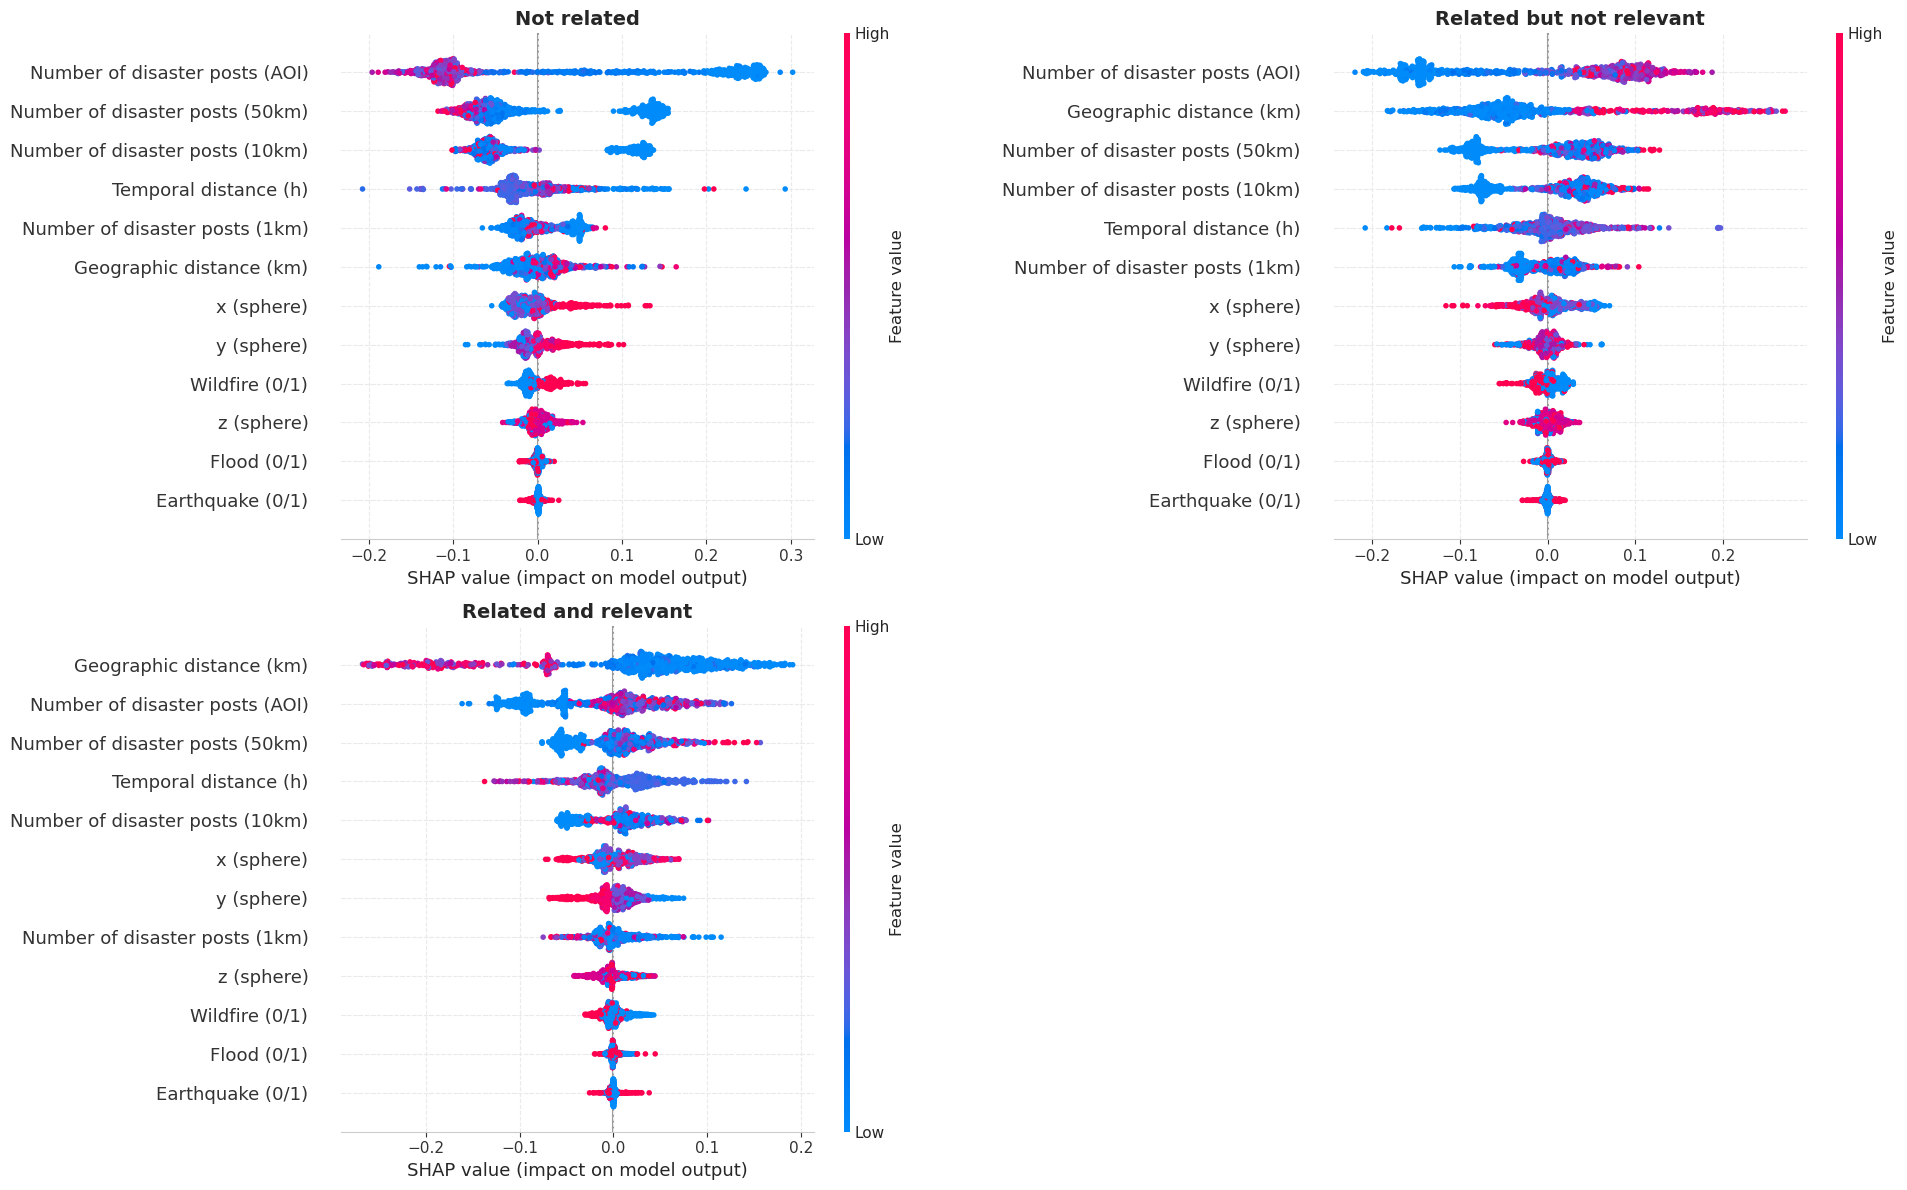

In [28]:
# Define labels
feature_names_raw: list = column_variant + ['flood', 'wildfire', 'earthquake', 'sphere_x', 'sphere_y', 'sphere_z']
feature_names: list = [non_text_labels.get(f, f) for f in feature_names_raw]

# Create empty figure
fig, axes = plt.subplots(2, 2)

# For demonstration, let's plot the summary for class 1.
# You can change the index if you prefer a different class.
plt.sca(axes[0, 0])
shap.summary_plot(
    shap_values[:,:,0], X_combined_test, 
    feature_names=feature_names,
    show=False
)
axes[0, 0].set_title("Not related", fontsize=14, fontweight='bold', loc='center') #  x=0.27

plt.sca(axes[0, 1])
shap.summary_plot(
    shap_values[:,:,1], X_combined_test, 
    feature_names=feature_names,
    show=False
)
axes[0, 1].set_title("Related but not relevant", fontsize=14, fontweight='bold', loc='center') # x=0.24

plt.sca(axes[1, 0])
shap.summary_plot(
    shap_values[:,:,2], X_combined_test, 
    feature_names=feature_names,
    show=False
)
axes[1, 0].set_title("Related and relevant", fontsize=14, fontweight='bold', loc='center')  # x=0.15
fig.delaxes(axes[1, 1])
plt.gcf().set_size_inches(20,12)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'non_text_model', 'shap_summary_plot_non_text.pdf'), dpi=300, bbox_inches='tight')

## 3. Text Classification
Next, we will visualise the result of text fine-tuning.

In [29]:
text_results: pd.DataFrame = pd.read_csv(os.path.join(RESULTS_PATH, 'fine_tuning', 'text_fine_tuning_metrics.csv'))
# text_results['val_f1'] = [0.8399600973431051, 0.8344411245900017]
text_results

,macro_precision,macro_recall,macro_f1,accuracy,macro_roc_auc,rmse,mae,model_name
0,0.794559,0.769935,0.778686,0.802186,0.928432,0.516398,0.220765,twhin-bert-base


We only need to print the results for our main text model.

In [30]:
print(text_results[['model_name', 'macro_f1', 'accuracy', 'macro_roc_auc', 'rmse']].to_latex(float_format="{:.3f}".format, index=False))

\begin{tabular}{lrrrr}
\toprule
model_name & macro_f1 & accuracy & macro_roc_auc & rmse \\
\midrule
twhin-bert-base & 0.779 & 0.802 & 0.928 & 0.516 \\
\bottomrule
\end{tabular}



## 4. Joint Classification
Lastly, we visualise the classification for spatio-temporally enhanced classification.

In [3]:
# load fine-tuning results
in_context_results: pd.DataFrame = pd.read_csv(os.path.join(RESULTS_PATH, 'fine_tuning', 'in_context_metrics.csv'))
extended_fine_tuning_results: pd.DataFrame = pd.read_csv(os.path.join(RESULTS_PATH, 'fine_tuning', 'extended_fine_tuning_metrics.csv'))

# filter only for the non-normalised features
extended_fine_tuning_results = extended_fine_tuning_results[extended_fine_tuning_results['variant'] == 'regular']

# add additional information
in_context_results['method'] = 'in_context'
extended_fine_tuning_results['method'] = 'concatenation'
fine_tuning_results: pd.DataFrame = pd.concat([in_context_results, extended_fine_tuning_results])
fine_tuning_results.rename(columns={
    'macro_precision': 'test_macro_prec', 'macro_recall': 'test_macro_rec',
    'macro_f1': 'test_macro_f1', 'accuracy': 'test_acc', 'macro_roc_auc': 'test_roc_auc', 'rmse': 'test_rmse',
    'mae': 'test_mae'
}, inplace=True)
print(fine_tuning_results.columns)

# add in the results from ensemble/meta learning
meta_learning_results: pd.DataFrame = pd.read_csv(os.path.join(RESULTS_PATH, 'classif_head', 'meta_learner_test.csv'))
meta_learning_val: pd.DataFrame = pd.read_csv(os.path.join(RESULTS_PATH, 'classif_head', 'meta_learner_validation.csv'))
meta_learning_results.rename(columns={
    'meta_method': 'method'
}, inplace=True)

joint_results: pd.DataFrame = pd.concat([fine_tuning_results, meta_learning_results])
joint_results.reset_index(inplace=True, drop=True)
joint_results

Index(['test_macro_prec', 'test_macro_rec', 'test_macro_f1', 'test_acc',
       'test_roc_auc', 'test_rmse', 'test_mae', 'model_name', 'method',
       'variant'],
      dtype='object')


,test_macro_prec,test_macro_rec,test_macro_f1,test_acc,test_roc_auc,test_rmse,test_mae,model_name,method,variant
0,0.791884,0.773861,0.780953,0.798907,0.923215,0.513213,0.221858,in_context,in_context,NaN
1,0.809894,0.806595,0.807456,0.821858,0.926434,0.516398,0.207650,extended_twhin-bert_simple,concatenation,regular
2,0.812329,0.813400,0.812458,0.825137,0.940497,0.522708,0.207650,extended_twhin-bert_complex,concatenation,regular
3,0.832501,0.799591,0.810704,0.831694,0.938008,0.486989,0.191257,logistic_regression,probabilities,NaN
4,0.823054,0.788032,0.799630,0.821858,0.930901,0.493676,0.200000,logistic_regression,partial,NaN
5,0.796501,0.789895,0.792667,0.809836,0.920972,0.508937,0.213115,random_forest,probabilities,NaN
6,0.831884,0.801935,0.812524,0.831694,0.931782,0.486989,0.191257,random_forest,partial,NaN
7,0.824932,0.788224,0.799943,0.824044,0.909566,0.494782,0.198907,svm,probabilities,NaN
8,0.656736,0.594951,0.574860,0.683060,0.855459,0.613153,0.336612,svm,partial,NaN
9,0.699900,0.705057,0.699323,0.726776,0.905003,0.718225,0.354098,gradient_boosting,probabilities,NaN


Now let's look at the best models. The reference score to beat is:
- `twhin-bert-base & 0.814 & 0.818 & 0.941 & 0.517`

In [4]:
joint_results_prnt: pd.DataFrame = joint_results[['model_name', 'method', 'test_macro_f1', 'test_acc', 'test_roc_auc', 'test_rmse']].copy()
joint_results_prnt.sort_values(by=['method', 'model_name'], ascending=True, inplace=True)
print(joint_results_prnt.to_latex(float_format="{:.3f}".format, index=False))

\begin{tabular}{llrrrr}
\toprule
model_name & method & test_macro_f1 & test_acc & test_roc_auc & test_rmse \\
\midrule
extended_twhin-bert_complex & concatenation & 0.812 & 0.825 & 0.940 & 0.523 \\
extended_twhin-bert_simple & concatenation & 0.807 & 0.822 & 0.926 & 0.516 \\
in_context & in_context & 0.781 & 0.799 & 0.923 & 0.513 \\
gradient_boosting & partial & 0.814 & 0.832 & 0.927 & 0.484 \\
knn & partial & 0.676 & 0.702 & 0.858 & 0.663 \\
logistic_regression & partial & 0.800 & 0.822 & 0.931 & 0.494 \\
naive_bayes & partial & 0.762 & 0.778 & 0.910 & 0.580 \\
random_forest & partial & 0.813 & 0.832 & 0.932 & 0.487 \\
svm & partial & 0.575 & 0.683 & 0.855 & 0.613 \\
gradient_boosting & probabilities & 0.699 & 0.727 & 0.905 & 0.718 \\
knn & probabilities & 0.790 & 0.813 & 0.916 & 0.512 \\
logistic_regression & probabilities & 0.811 & 0.832 & 0.938 & 0.487 \\
naive_bayes & probabilities & 0.797 & 0.817 & 0.932 & 0.505 \\
random_forest & probabilities & 0.793 & 0.810 & 0.921 & 0.509 \\


### 4.1 SHAP Analysis
Just like for the pure non-text features, we can also analyse the SHAP values for our best meta-learner. We need quite a bit of preparation to achieve that.

In [5]:
train_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'fine_tuning', 'train_data.parquet'))
test_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'fine_tuning', 'test_data.parquet'))

# Define the event and location encoding options
encoding_options = {
    "none": lambda df: np.empty((df.shape[0], 0)),  # returns an empty array so hstack works
    "event_type_encoding": lambda df: np.vstack(df['event_type_encoding'].values),
    "sphere_coords": lambda df: df[['sphere_x', 'sphere_y', 'sphere_z']].values,
    "all": lambda df: np.hstack([
        np.vstack(df['event_type_encoding'].values),
        df[['sphere_x', 'sphere_y', 'sphere_z']].values
    ])
}

# Construct the feature matrix for the training data
X_base_train: np.ndarray = train_gdf[NON_TEXT_COLUMNS].values  # base features
X_event_train: np.ndarray = encoding_options['all'](train_gdf)  # event encoding features
X_train_non_text: np.ndarray = np.hstack([X_base_train, X_event_train])
X_train_text: np.ndarray = train_gdf['text'].values
y_train: np.ndarray = train_gdf['int_label'].values

# Construct the feature matrix for the test data
X_base_test: np.ndarray = test_gdf[NON_TEXT_COLUMNS].values  # base features
X_event_test: np.ndarray = encoding_options['all'](test_gdf)  # event encoding features
X_test_text: np.ndarray = test_gdf['text'].values
X_test_non_text: np.ndarray = np.hstack([X_base_test, X_event_test])
y_test: np.ndarray = test_gdf['int_label'].values

print(X_train_non_text.shape, X_train_text.shape)
print(X_test_non_text.shape, X_test_text.shape)

# Our text model already has been fine-tuned
classifier_full = pipeline(
    "text-classification", 
    model=os.path.join(DATA_PATH, 'models', f'twhin-bert-base_ft', 'model'),
    device=0, 
    return_all_scores=True
)

# For the non-text model, we should train an optimal one based on the random forest
# Here, optimise_model is assumed to be a function that performs hyperparameter tuning
non_text_model_full, non_text_params_full, non_text_f1_full = optimise_model(
    GradientBoostingClassifier(random_state=2), X_train_non_text, y_train)
print(f'Fitted non-text model (random forest) with validation macro F1: {non_text_f1_full}')
print(non_text_params_full)

# Get class probabilities for the text model
text_predictions_test = []
for text in X_test_text.tolist():
    text_predictions_test.append(extract_probabilities(text=text, classifier=classifier_full))
text_prediction_df_test = pd.DataFrame.from_dict(text_predictions_test)
# Make sure the columns order is the same as in training, i.e., ['p_not_related', 'p_related_but_not_relevant', 'p_related_and_relevant']
test_preds_text = text_prediction_df_test[['p_not_related', 'p_related_but_not_relevant', 'p_related_and_relevant']].values

# Features based on text probabilities and non-text features
meta_part_features_test: np.ndarray = np.concatenate([X_test_non_text, test_preds_text], axis=1)  # shape: [n_test, n_classes+12=15]
print(meta_part_features_test.shape)

(3659, 12) (3659,)
(915, 12) (915,)


/home/david/miniconda3/envs/active-learning/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Fitted non-text model (random forest) with validation macro F1: 0.6926318629972742
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


(915, 15)


Next, we can make load our meta learning model and compute SHAP values.

In [7]:
# Load the pickle file containing meta training results
pickle_path = os.path.join(RESULTS_PATH, 'classif_head', 'meta_learner_models.pickle')
with open(pickle_path, 'rb') as f:
    meta_models = pickle.load(f)

# # Filter for the random_forest model with method 'partial'
shap_model = [res for res in meta_models if res['model_name'] == 'random_forest' and res['method'] == 'partial'][0]['model']
if not shap_model:
    raise ValueError("No random_forest model with method 'partial' found in the pickle file.")

# Create a SHAP TreeExplainer for the random forest model
# Unfortunataly, gradient boosting is only supported for binary classification!
explainer = shap.TreeExplainer(shap_model)

# Compute SHAP values using the meta_part_features_train (assumed to be available)
# For multi-class models, shap_values will be a list of arrays, one for each class.
shap_values = explainer.shap_values(X=meta_part_features_test)

And lastly, we can visualise the values.

/home/david/miniconda3/envs/active-learning/lib/python3.12/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  pl.tight_layout()


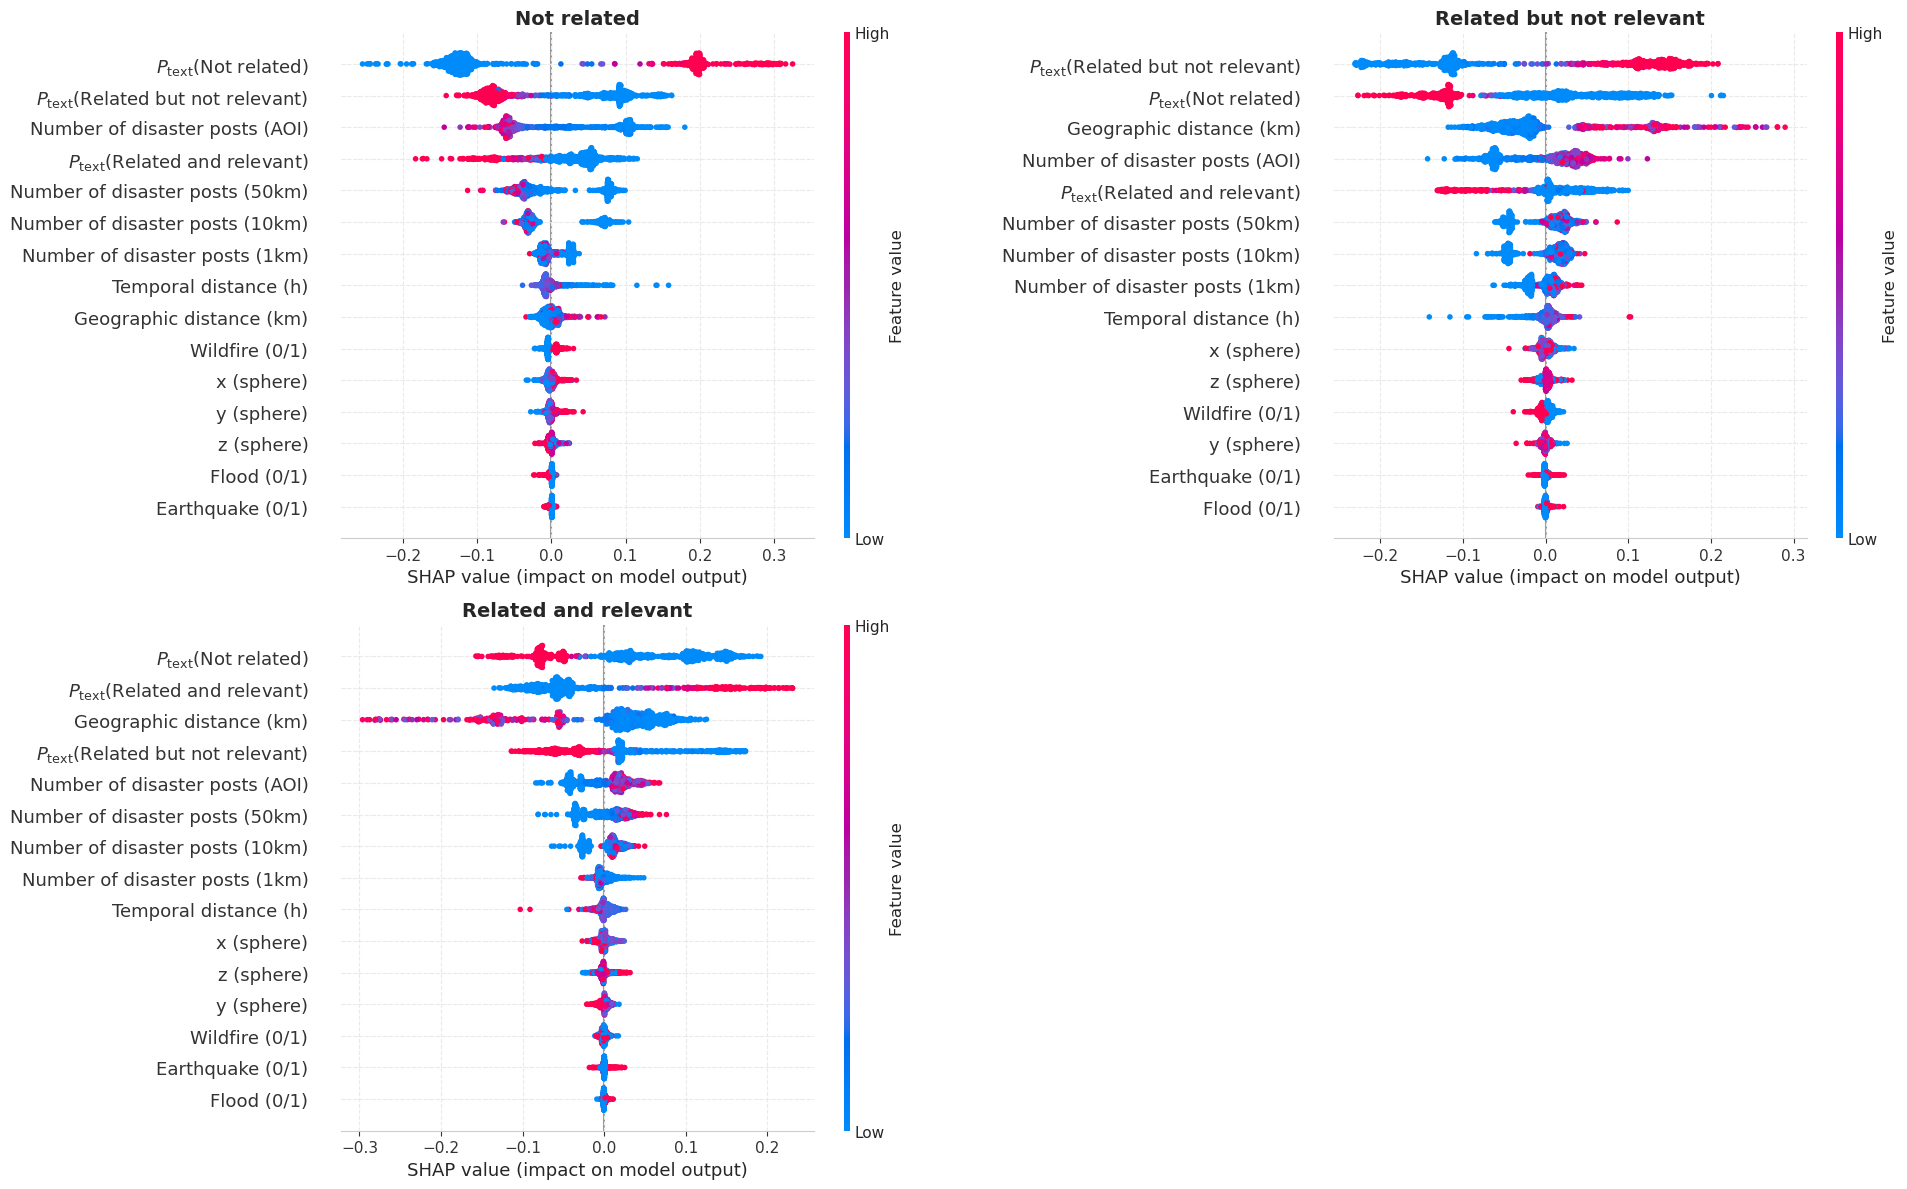

In [8]:
# Define labels
feature_names_raw: list = NON_TEXT_COLUMNS_NORM + ['flood', 'wildfire', 'earthquake', 'sphere_x', 'sphere_y', 'sphere_z'] + ['p_not_related', 'p_related_but_not_relevant', 'p_related_and_relevant']
feature_names: list = [non_text_labels.get(f, f) for f in feature_names_raw]

# Create empty figure
fig, axes = plt.subplots(2, 2)

# For demonstration, let's plot the summary for class 1.
# You can change the index if you prefer a different class.
plt.sca(axes[0, 0])
shap.summary_plot(
    shap_values[:,:,0], meta_part_features_test, 
    feature_names=feature_names,
    show=False
)
axes[0, 0].set_title("Not related", fontsize=14, fontweight='bold', loc='center') #  x=0.27

plt.sca(axes[0, 1])
shap.summary_plot(
    shap_values[:,:,1], meta_part_features_test, 
    feature_names=feature_names,
    show=False
)
axes[0, 1].set_title("Related but not relevant", fontsize=14, fontweight='bold', loc='center') # x=0.24

plt.sca(axes[1, 0])
shap.summary_plot(
    shap_values[:,:,2], meta_part_features_test, 
    feature_names=feature_names,
    show=False
)
axes[1, 0].set_title("Related and relevant", fontsize=14, fontweight='bold', loc='center')  # x=0.15
fig.delaxes(axes[1, 1])
plt.gcf().set_size_inches(20,12)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'classif_head', 'shap_summary_plot_joint.pdf'), dpi=300, bbox_inches='tight')

## 5. Use Case Comparison

Okay, so that is what we saw globally. What if we want to compare the evaluation metrics per use case.

In [17]:
text_preds: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(RESULTS_PATH, 'fine_tuning', 'pred_text_twhin-bert-base.parquet'))
joint_preds: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(RESULTS_PATH, 'classif_head', 'meta_learning_preds.parquet'))
non_text_preds: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(RESULTS_PATH, 'non_text_model', 'pred_non_text.parquet'))
non_text_preds.rename(columns={'pred_random_forest_regular_event_type_encoding_sphere_coords': 'prediction'}, inplace=True)
joint_preds.rename(columns={'pred_partial_gradient_boosting': 'prediction'}, inplace=True)
print(text_preds.shape, joint_preds.shape, non_text_preds.shape)

(915, 46) (915, 57) (915, 93)


Next, let's compute the evaluation metrics.

In [44]:
use_case_metrics_text: pd.DataFrame = get_group_metrics(text_preds)
use_case_metrics_text['approach'] = 'Text'
use_case_metrics_non_text: pd.DataFrame = get_group_metrics(non_text_preds)
use_case_metrics_non_text['approach'] = 'Non-text'
use_case_metrics_joint: pd.DataFrame = get_group_metrics(joint_preds)
use_case_metrics_joint['approach'] = 'Multimodal'

use_case_metrics: pd.DataFrame = pd.concat([
    use_case_metrics_text, use_case_metrics_non_text, use_case_metrics_joint
])
use_case_metrics['use_case_label'] = use_case_metrics['use_case'].map(use_case_labels)
use_case_metrics

,use_case,accuracy,precision,recall,f1,support,approach,use_case_label
0,California 🔥,0.725490,0.740522,0.723419,0.723628,204,Text,California wildfires
1,Turkey 🪨,0.778261,0.722720,0.706360,0.713289,230,Text,Turkey earthquake
2,Chile 🔥,0.840764,0.838888,0.772106,0.790619,157,Text,Chile wildfires
3,Germany 🌊,0.839286,0.826106,0.785455,0.800675,224,Text,Ahr Valley floods
4,Italy 🌊,0.870000,0.872624,0.871780,0.870172,100,Text,Emilia-Romagna floods
0,California 🔥,0.529412,0.533373,0.522617,0.525606,204,Non-text,California wildfires
1,Turkey 🪨,0.839130,0.822451,0.833179,0.825145,230,Non-text,Turkey earthquake
2,Chile 🔥,0.751592,0.719404,0.677933,0.688401,157,Non-text,Chile wildfires
3,Germany 🌊,0.781250,0.763015,0.738233,0.748223,224,Non-text,Ahr Valley floods
4,Italy 🌊,0.750000,0.747267,0.749459,0.748243,100,Non-text,Emilia-Romagna floods


With that in mind, we can immediately visualise.

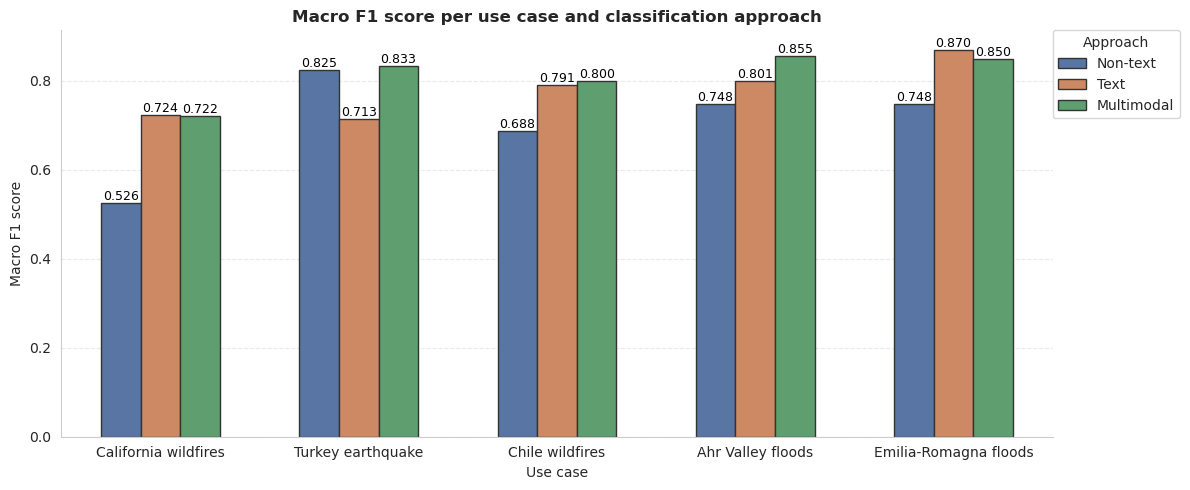

In [57]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(data=use_case_metrics, y='f1', x='use_case_label', hue='approach', palette='deep',  # palette=modern_palette
            width=0.6,
            edgecolor='0.2',   # Slightly darker edge color for clarity
            linewidth=1.0,     # Thicker outline helps define each bar
            hue_order=["Non-text", "Text", "Multimodal"],
)
ax.set_ylabel('Macro F1 score')
ax.set_xlabel('Use case')
ax.get_legend().set_title('Approach')
sns.despine(ax=ax)

# Annotate each bar with its value (rounded to two decimals)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        # Slightly offset above the bar
        ax.annotate(f'{height:.3f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black')

# Move the legend outside the plot
ax.legend(
    bbox_to_anchor=(1.0, 1),
    loc='upper left',
    borderaxespad=0,
    title='Approach',
)
ax.set_title('Macro F1 score per use case and classification approach', fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(RESULTS_PATH, 'classif_head', 'use_case_f1_scores_bar.pdf'), dpi=300, bbox_inches='tight')

Perhaps a table also makes sense.

In [36]:
use_case_metrics_pivot: pd.DataFrame = use_case_metrics.pivot_table(
    columns='use_case_label', 
    index='approach', 
    values='f1'
).reset_index()
use_case_metrics_pivot = use_case_metrics_pivot
print(use_case_metrics_pivot.to_latex(float_format="{:.3f}".format, index=False))

\begin{tabular}{lrrrrr}
\toprule
approach & Ahr Valley floods & California wildfires & Chile wildfires & Emilia-Romagna floods & Turkey earthquake \\
\midrule
Non-text & 0.748 & 0.526 & 0.688 & 0.748 & 0.825 \\
Text + non-text & 0.855 & 0.722 & 0.800 & 0.850 & 0.833 \\
Text-only & 0.801 & 0.724 & 0.791 & 0.870 & 0.713 \\
\bottomrule
\end{tabular}



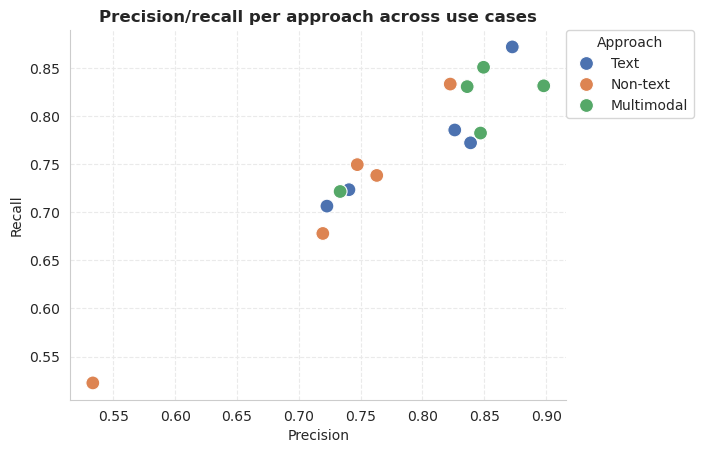

In [46]:
fig, ax = plt.subplots()
sns.scatterplot(data=use_case_metrics, x='precision', y='recall', hue='approach', palette='deep', s=100, ax=ax)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')

# Move the legend outside the plot
ax.legend(
    bbox_to_anchor=(1.0, 1),
    loc='upper left',
    borderaxespad=0,
    title='Approach',
)
ax.set_title('Precision/recall per approach across use cases', fontsize=12, fontweight='bold')
sns.despine(ax=ax)
fig.savefig(os.path.join(RESULTS_PATH, 'classif_head', 'use_case_prec_rec.pdf'), dpi=300, bbox_inches='tight')

Also, how are the use cases covered in the test data?

In [38]:
test_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'fine_tuning', 'test_data.parquet'))
test_gdf.groupby('use_case').size()

use_case
California 🔥    204
Chile 🔥         157
Germany 🌊       224
Italy 🌊         100
Turkey 🪨        230
dtype: int64

## 6. Overlap in Misclassifications
Where do the misclassifications overlap?

In [39]:
text_preds: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(RESULTS_PATH, 'fine_tuning', 'pred_text_twhin-bert-base.parquet'))
joint_preds: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(RESULTS_PATH, 'classif_head', 'meta_learning_preds.parquet'))
non_text_preds: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(RESULTS_PATH, 'non_text_model', 'pred_non_text.parquet'))
non_text_preds.rename(columns={'pred_random_forest_regular_event_type_encoding_sphere_coords': 'prediction'}, inplace=True)
joint_preds.rename(columns={'pred_partial_gradient_boosting': 'prediction'}, inplace=True)
print(text_preds.shape, joint_preds.shape, non_text_preds.shape)

(915, 46) (915, 57) (915, 93)


In [41]:
from sklearn.metrics import cohen_kappa_score

# Compute misclassified rows for each classifier
text_mis = text_preds[text_preds['prediction'] != text_preds['int_label']]
joint_mis = joint_preds[joint_preds['prediction'] != joint_preds['int_label']]
non_text_mis = non_text_preds[non_text_preds['prediction'] != non_text_preds['int_label']]

# Print raw misclassification counts
print(f"Text misclassifications: {len(text_mis)}")
print(f"Joint misclassifications: {len(joint_mis)}")
print(f"Non-text misclassifications: {len(non_text_mis)}")

# Total number of samples (assuming same for all predictions)
total_samples = len(text_preds)

# 1. Overall misclassification rates
text_error_rate = (len(text_mis) / total_samples) * 100
joint_error_rate = (len(joint_mis) / total_samples) * 100
non_text_error_rate = (len(non_text_mis) / total_samples) * 100

print(f"Text error rate: {text_error_rate:.2f}%")
print(f"Joint error rate: {joint_error_rate:.2f}%")
print(f"Non-text error rate: {non_text_error_rate:.2f}%")

# 2. Pairwise intersections between misclassifications (by index)
common_text_non_text = text_mis.index.intersection(non_text_mis.index)
common_text_joint = text_mis.index.intersection(joint_mis.index)
common_joint_non_text = joint_mis.index.intersection(non_text_mis.index)
common_all = text_mis.index.intersection(joint_mis.index).intersection(non_text_mis.index)

# Percentages relative to each classifier's misclassifications:
percent_text_in_non_text = (len(common_text_non_text) / len(text_mis)) * 100 if len(text_mis) > 0 else 0
percent_non_text_in_text = (len(common_text_non_text) / len(non_text_mis)) * 100 if len(non_text_mis) > 0 else 0

percent_text_in_joint = (len(common_text_joint) / len(text_mis)) * 100 if len(text_mis) > 0 else 0
percent_joint_in_text = (len(common_text_joint) / len(joint_mis)) * 100 if len(joint_mis) > 0 else 0

percent_joint_in_non_text = (len(common_joint_non_text) / len(joint_mis)) * 100 if len(joint_mis) > 0 else 0
percent_non_text_in_joint = (len(common_joint_non_text) / len(non_text_mis)) * 100 if len(non_text_mis) > 0 else 0

print(f"Percentage of text misclassifications also in non-text: {percent_text_in_non_text:.2f}%")
print(f"Percentage of non-text misclassifications also in text: {percent_non_text_in_text:.2f}%")

print(f"Percentage of text misclassifications also in joint: {percent_text_in_joint:.2f}%")
print(f"Percentage of joint misclassifications also in text: {percent_joint_in_text:.2f}%")

print(f"Percentage of joint misclassifications also in non-text: {percent_joint_in_non_text:.2f}%")
print(f"Percentage of non-text misclassifications also in joint: {percent_non_text_in_joint:.2f}%")

# 3. Unique misclassifications (errors exclusive to one classifier)
unique_text = text_mis.index.difference(joint_mis.index.union(non_text_mis.index))
unique_non_text = non_text_mis.index.difference(text_mis.index.union(joint_mis.index))
unique_joint = joint_mis.index.difference(text_mis.index.union(non_text_mis.index))

print(f"Unique text misclassifications: {len(unique_text)}")
print(f"Unique non-text misclassifications: {len(unique_non_text)}")
print(f"Unique joint misclassifications: {len(unique_joint)}")

# 4. Consensus misclassification rate (all three classifiers misclassify)
consensus_error_rate = (len(common_all) / total_samples) * 100
print(f"Consensus error rate (misclassified by all three): {consensus_error_rate:.2f}%")

# 5. Pairwise consensus error rates (percentage of total samples misclassified by each pair)
consensus_rate_text_non_text = (len(common_text_non_text) / total_samples) * 100
consensus_rate_text_joint = (len(common_text_joint) / total_samples) * 100
consensus_rate_joint_non_text = (len(common_joint_non_text) / total_samples) * 100

print(f"Consensus error rate (Text & Non-text): {consensus_rate_text_non_text:.2f}%")
print(f"Consensus error rate (Text & Joint): {consensus_rate_text_joint:.2f}%")
print(f"Consensus error rate (Joint & Non-text): {consensus_rate_joint_non_text:.2f}%")

# 6. Cohen's Kappa for pairwise prediction agreement
kappa_text_non_text = cohen_kappa_score(text_preds['prediction'], non_text_preds['prediction'])
kappa_text_joint = cohen_kappa_score(text_preds['prediction'], joint_preds['prediction'])
kappa_non_text_joint = cohen_kappa_score(non_text_preds['prediction'], joint_preds['prediction'])

print(f"Cohen's Kappa (Text vs Non-text): {kappa_text_non_text:.2f}")
print(f"Cohen's Kappa (Text vs Joint): {kappa_text_joint:.2f}")
print(f"Cohen's Kappa (Non-text vs Joint): {kappa_non_text_joint:.2f}")

Text misclassifications: 181
Joint misclassifications: 154
Non-text misclassifications: 246
Text error rate: 19.78%
Joint error rate: 16.83%
Non-text error rate: 26.89%
Percentage of text misclassifications also in non-text: 45.30%
Percentage of non-text misclassifications also in text: 33.33%
Percentage of text misclassifications also in joint: 74.59%
Percentage of joint misclassifications also in text: 87.66%
Percentage of joint misclassifications also in non-text: 52.60%
Percentage of non-text misclassifications also in joint: 32.93%
Unique text misclassifications: 37
Unique non-text misclassifications: 156
Unique joint misclassifications: 11
Consensus error rate (misclassified by all three): 7.98%
Consensus error rate (Text & Non-text): 8.96%
Consensus error rate (Text & Joint): 14.75%
Consensus error rate (Joint & Non-text): 8.85%
Cohen's Kappa (Text vs Non-text): 0.49
Cohen's Kappa (Text vs Joint): 0.88
Cohen's Kappa (Non-text vs Joint): 0.54


## 6. Class Comparison
We might also compare the performance across classes.

In [47]:
text_preds: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(RESULTS_PATH, 'fine_tuning', 'pred_text_twhin-bert-base.parquet'))
joint_preds: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(RESULTS_PATH, 'classif_head', 'meta_learning_preds.parquet'))
non_text_preds: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(RESULTS_PATH, 'non_text_model', 'pred_non_text.parquet'))
non_text_preds.rename(columns={'pred_random_forest_regular_event_type_encoding_sphere_coords': 'prediction'}, inplace=True)
joint_preds.rename(columns={'pred_partial_gradient_boosting': 'prediction'}, inplace=True)
print(text_preds.shape, joint_preds.shape, non_text_preds.shape)

(915, 46) (915, 57) (915, 93)


In [54]:
# Compute metrics for each approach
class_metrics_text = get_class_metrics(text_preds)
class_metrics_text['approach'] = 'Text'

class_metrics_non_text = get_class_metrics(non_text_preds)
class_metrics_non_text['approach'] = 'Non-text'

class_metrics_joint = get_class_metrics(joint_preds)
class_metrics_joint['approach'] = 'Multimodal'

# Optionally, combine the results into one DataFrame for side-by-side comparison
class_metrics: pd.DataFrame = pd.concat([
    class_metrics_text, 
    class_metrics_non_text, 
    class_metrics_joint
], ignore_index=True)
class_metrics['class'] = class_metrics['class'].map({
    0: 'Not related',
    1: 'Related but not relevant',
    2: 'Related and relevant'
})
class_metrics

,class,precision,recall,f1,approach
0,Not related,0.933333,0.851064,0.890302,Text
1,Related but not relevant,0.753915,0.870801,0.808153,Text
2,Related and relevant,0.696429,0.587940,0.637602,Text
3,Not related,0.824281,0.784195,0.803738,Non-text
4,Related but not relevant,0.717762,0.762274,0.739348,Non-text
5,Related and relevant,0.607330,0.582915,0.594872,Non-text
6,Not related,0.928105,0.863222,0.894488,Multimodal
7,Related but not relevant,0.789474,0.891473,0.837379,Multimodal
8,Related and relevant,0.767442,0.663317,0.711590,Multimodal


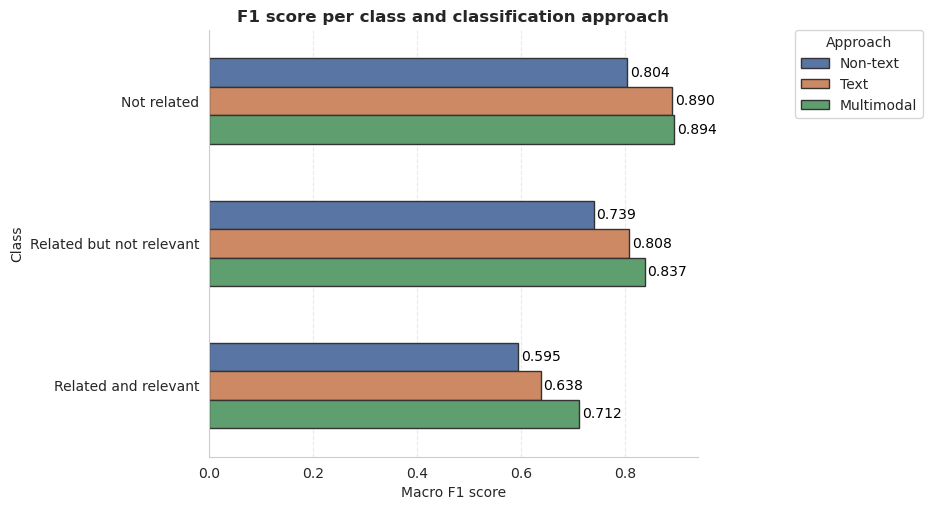

In [58]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=class_metrics, x='f1', y='class', hue='approach', 
            # palette=model_palette,
            palette='deep', hue_order=["Non-text", "Text", "Multimodal"],
            width=0.6, edgecolor='0.2', linewidth=1.0)
ax.set_ylabel('Class')
ax.set_xlabel('Macro F1 score')
ax.get_legend().set_title('Approach')
sns.despine(ax=ax)

# Annotate each bar with its value (rounded to two decimals) for a horizontal bar plot
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.annotate(
            f'{width:.3f}', 
            (width, p.get_y() + p.get_height()/2),
            ha='left', 
            va='center', 
            fontsize=10, 
            color='black',
            xytext=(2, 0), 
            textcoords='offset points'
        )


# Move the legend outside the plot
ax.legend(
    bbox_to_anchor=(1.2, 1),
    loc='upper left',
    borderaxespad=0,
    title='Approach',
)
fig.tight_layout()
ax.set_title('F1 score per class and classification approach', fontsize=12, fontweight='bold')
fig.savefig(os.path.join(RESULTS_PATH, 'classif_head', 'f1_per_class.pdf'), dpi=300, bbox_inches='tight')

In [51]:
class_metrics_pivot: pd.DataFrame = class_metrics.pivot_table(
    columns='approach', 
    index='class', 
    values='f1'
).reset_index()
print(class_metrics_pivot.to_latex(float_format="{:.3f}".format, index=False))

\begin{tabular}{lrrr}
\toprule
class & Non-text & Text + non-text & Text-only \\
\midrule
Not related & 0.804 & 0.894 & 0.890 \\
Related and relevant & 0.595 & 0.712 & 0.638 \\
Related but not relevant & 0.739 & 0.837 & 0.808 \\
\bottomrule
\end{tabular}



## 7. Binarisation
Lastly, let's try some random stuff. What if we binarise our results?

In [65]:
# Read in the GeoDataFrames
text_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'fine_tuning', 'pred_text_twhin-bert-base.parquet'))
joint_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'classif_head', 'meta_learning_preds.parquet'))
non_text_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'non_text_model', 'pred_non_text.parquet'))

# Rename prediction columns where necessary
non_text_preds.rename(columns={'pred_random_forest_regular_event_type_encoding_sphere_coords': 'prediction'}, inplace=True)
joint_preds.rename(columns={'pred_partial_gradient_boosting': 'prediction'}, inplace=True)

# Map int_label to binary labels and predictions (0 for classes 0 and 1, and 1 for class 2)
mapping = {0: 0, 1: 0, 2: 1}

joint_preds['binary_label'] = joint_preds['int_label'].map(mapping)
joint_preds['binary_pred'] = joint_preds['prediction'].map(mapping)
text_preds['binary_label'] = text_preds['int_label'].map(mapping)
text_preds['binary_pred'] = text_preds['prediction'].map(mapping)
non_text_preds['binary_label'] = non_text_preds['int_label'].map(mapping)
non_text_preds['binary_pred'] = non_text_preds['prediction'].map(mapping)

# Compute F1 scores for each set (default binary F1 with pos_label=1)
_, _, f1_non_text, _ = precision_recall_fscore_support(non_text_preds['binary_label'], non_text_preds['binary_pred'], average='macro')
_, _, f1_text, _ = precision_recall_fscore_support(text_preds['binary_label'], text_preds['binary_pred'], average='macro')
_, _, f1_joint, _ = precision_recall_fscore_support(joint_preds['binary_label'], joint_preds['binary_pred'], average='macro')
acc_non_text = accuracy_score(non_text_preds['binary_label'], non_text_preds['binary_pred'])
acc_text = accuracy_score(text_preds['binary_label'], text_preds['binary_pred'])
acc_joint = accuracy_score(joint_preds['binary_label'], joint_preds['binary_pred'])

# Create a single dataframe with three columns for the F1 scores
metrics_relevance = pd.DataFrame({
    'scheme': 'Binary relevance',
    'non-text_f1': [f1_non_text],
    'non-text_acc': [acc_non_text],
    'text_f1': [f1_text],
    'text_acc': [acc_text],
    'multimodal_f1': [f1_joint],
    'multimodal_acc': [acc_joint],
})

metrics_relevance

,scheme,non-text_f1,non-text_acc,text_f1,text_acc,multimodal_f1,multimodal_acc
0,Binary relevance,0.742575,0.827322,0.773347,0.854645,0.819126,0.88306


In [69]:
# Read in the GeoDataFrames
text_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'fine_tuning', 'pred_text_twhin-bert-base.parquet'))
joint_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'classif_head', 'meta_learning_preds.parquet'))
non_text_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'non_text_model', 'pred_non_text.parquet'))

# Rename prediction columns where necessary
non_text_preds.rename(columns={'pred_random_forest_regular_event_type_encoding_sphere_coords': 'prediction'}, inplace=True)
joint_preds.rename(columns={'pred_partial_gradient_boosting': 'prediction'}, inplace=True)

# Map int_label to binary labels and predictions (0 for classes 0 and 1, and 1 for class 2)
mapping = {0: 0, 1: 1, 2: 1}

joint_preds['binary_label'] = joint_preds['int_label'].map(mapping)
joint_preds['binary_pred'] = joint_preds['prediction'].map(mapping)
text_preds['binary_label'] = text_preds['int_label'].map(mapping)
text_preds['binary_pred'] = text_preds['prediction'].map(mapping)
non_text_preds['binary_label'] = non_text_preds['int_label'].map(mapping)
non_text_preds['binary_pred'] = non_text_preds['prediction'].map(mapping)

# Compute F1 scores for each set (default binary F1 with pos_label=1)
_, _, f1_non_text, _ = precision_recall_fscore_support(non_text_preds['binary_label'], non_text_preds['binary_pred'], average='macro')
_, _, f1_text, _ = precision_recall_fscore_support(text_preds['binary_label'], text_preds['binary_pred'], average='macro')
_, _, f1_joint, _ = precision_recall_fscore_support(joint_preds['binary_label'], joint_preds['binary_pred'], average='macro')
acc_non_text = accuracy_score(non_text_preds['binary_label'], non_text_preds['binary_pred'])
acc_text = accuracy_score(text_preds['binary_label'], text_preds['binary_pred'])
acc_joint = accuracy_score(joint_preds['binary_label'], joint_preds['binary_pred'])

# Create a single dataframe with three columns for the F1 scores
metrics_relatedness = pd.DataFrame({
    'scheme': 'Binary relevance',
    'non-text_f1': [f1_non_text],
    'non-text_acc': [acc_non_text],
    'text_f1': [f1_text],
    'text_acc': [acc_text],
    'multimodal_f1': [f1_joint],
    'multimodal_acc': [acc_joint],
})
print(metrics_relatedness)

             scheme  non-text_f1  non-text_acc   text_f1  text_acc  \
0  Binary relevance     0.848839      0.862295  0.916425   0.92459   

   multimodal_f1  multimodal_acc  
0       0.919211        0.926776  


In [71]:
data = {
    "Non-text": {
        ("Disaster-relatedness (0/1)", "Macro F1"): metrics_relatedness.loc[0, "non-text_f1"],
        ("Disaster-relatedness (0/1)", "Accuracy"): metrics_relatedness.loc[0, "non-text_acc"],
        ("Relevance (0/1)", "Macro F1"): metrics_relevance.loc[0, "non-text_f1"],
        ("Relevance (0/1)", "Accuracy"): metrics_relevance.loc[0, "non-text_acc"]
    },
    "Text": {
        ("Disaster-relatedness (0/1)", "Macro F1"): metrics_relatedness.loc[0, "text_f1"],
        ("Disaster-relatedness (0/1)", "Accuracy"): metrics_relatedness.loc[0, "text_acc"],
        ("Relevance (0/1)", "Macro F1"): metrics_relevance.loc[0, "text_f1"],
        ("Relevance (0/1)", "Accuracy"): metrics_relevance.loc[0, "text_acc"]
    },
    "Multimodal": {
        ("Disaster-relatedness (0/1)", "Macro F1"): metrics_relatedness.loc[0, "multimodal_f1"],
        ("Disaster-relatedness (0/1)", "Accuracy"): metrics_relatedness.loc[0, "multimodal_acc"],
        ("Relevance (0/1)", "Macro F1"): metrics_relevance.loc[0, "multimodal_f1"],
        ("Relevance (0/1)", "Accuracy"): metrics_relevance.loc[0, "multimodal_acc"]
    }
}

# Convert the nested dictionary to a DataFrame;
# the outer keys become the row index ("Method") and the inner keys become the MultiIndex columns.
df_combined = pd.DataFrame.from_dict(data, orient="index")
df_combined.index.name = "Method"

# To ensure the methods appear in the desired order, reindex if needed:
df_combined = df_combined.reindex(["Non-text", "Text", "Multimodal"])

# Optional: Format the numbers to three decimals (as strings) if desired:
df_display = df_combined.applymap(lambda x: f"{x:.3f}")

print(df_display.to_latex(float_format="{:.3f}".format, index=True))

\begin{tabular}{lllll}
\toprule
 & \multicolumn{2}{r}{Disaster-relatedness (0/1)} & \multicolumn{2}{r}{Relevance (0/1)} \\
 & Macro F1 & Accuracy & Macro F1 & Accuracy \\
Method &  &  &  &  \\
\midrule
Non-text & 0.849 & 0.862 & 0.743 & 0.827 \\
Text & 0.916 & 0.925 & 0.773 & 0.855 \\
Multimodal & 0.919 & 0.927 & 0.819 & 0.883 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_960/4104497846.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_display = df_combined.applymap(lambda x: f"{x:.3f}")


Okay, at the very end it would also be good to see the performance per use case.

In [96]:
# Read in the GeoDataFrames
text_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'fine_tuning', 'pred_text_twhin-bert-base.parquet'))
joint_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'classif_head', 'meta_learning_preds.parquet'))
non_text_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'non_text_model', 'pred_non_text.parquet'))

# Rename prediction columns where necessary
non_text_preds.rename(columns={'pred_random_forest_regular_event_type_encoding_sphere_coords': 'prediction'}, inplace=True)
joint_preds.rename(columns={'pred_partial_gradient_boosting': 'prediction'}, inplace=True)

# Map int_label to binary labels and predictions (0 for classes 0 and 1, and 1 for class 2)
mapping = {0: 0, 1: 0, 2: 1}

for df in [text_preds, joint_preds, non_text_preds]:
    df['binary_label'] = df['int_label'].map(mapping)
    df['binary_pred'] = df['prediction'].map(mapping)

# Define a helper function to compute macro F1 for a given group
def compute_macro_f1(df):
    # The third element returned is the F1 score when average='macro'
    f1 = precision_recall_fscore_support(df['binary_label'], df['binary_pred'], average='macro')[2]
    return f1

# Compute macro F1 scores per use_case for each DataFrame
non_text_f1 = non_text_preds.groupby('use_case').apply(compute_macro_f1, include_groups=False).reset_index(name='non_text')
text_f1 = text_preds.groupby('use_case').apply(compute_macro_f1, include_groups=False).reset_index(name='text')
joint_f1 = joint_preds.groupby('use_case').apply(compute_macro_f1, include_groups=False).reset_index(name='text+non_text')

# Merge the three results on the "use_case" column
df_f1_per_use_case = non_text_f1.merge(text_f1, on='use_case', how='outer').merge(joint_f1, on='use_case', how='outer')

# Add a column to label the scheme (optional)
df_f1_per_use_case['scheme'] = 'Binary relevance'

# Rearrange columns (scheme, use_case, non-text, text, text+non-text)
df_f1_per_use_case = df_f1_per_use_case[['scheme', 'use_case', 'non_text', 'text', 'text+non_text']]

print(df_f1_per_use_case)

             scheme      use_case  non_text      text  text+non_text
0  Binary relevance  California 🔥  0.602430  0.766323       0.759093
1  Binary relevance       Chile 🔥  0.697654  0.780112       0.780112
2  Binary relevance     Germany 🌊  0.774050  0.785859       0.868375
3  Binary relevance       Italy 🌊  0.780220  0.886929       0.866310
4  Binary relevance      Turkey 🪨  0.848471  0.649924       0.814740


In [97]:
# Read in the GeoDataFrames
text_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'fine_tuning', 'pred_text_twhin-bert-base.parquet'))
joint_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'classif_head', 'meta_learning_preds.parquet'))
non_text_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'non_text_model', 'pred_non_text.parquet'))

# Rename prediction columns where necessary
non_text_preds.rename(columns={'pred_random_forest_regular_event_type_encoding_sphere_coords': 'prediction'}, inplace=True)
joint_preds.rename(columns={'pred_partial_gradient_boosting': 'prediction'}, inplace=True)

# Map int_label to binary labels and predictions (0 for classes 0 and 1, and 1 for class 2)
mapping = {0: 0, 1: 1, 2: 1}

for df in [text_preds, joint_preds, non_text_preds]:
    df['binary_label'] = df['int_label'].map(mapping)
    df['binary_pred'] = df['prediction'].map(mapping)

# Define a helper function to compute macro F1 for a given group
def compute_macro_f1(df):
    # The third element returned is the F1 score when average='macro'
    f1 = precision_recall_fscore_support(df['binary_label'], df['binary_pred'], average='macro')[2]
    return f1

# Compute macro F1 scores per use_case for each DataFrame
non_text_f1 = non_text_preds.groupby('use_case').apply(compute_macro_f1, include_groups=False).reset_index(name='non_text')
text_f1 = text_preds.groupby('use_case').apply(compute_macro_f1, include_groups=False).reset_index(name='text')
joint_f1 = joint_preds.groupby('use_case').apply(compute_macro_f1, include_groups=False).reset_index(name='text+non_text')

# Merge the three results on the "use_case" column
df_f1_per_use_case = non_text_f1.merge(text_f1, on='use_case', how='outer').merge(joint_f1, on='use_case', how='outer')

# Add a column to label the scheme (optional)
df_f1_per_use_case['scheme'] = 'Binary relatedness'

# Rearrange columns (scheme, use_case, non-text, text, text+non-text)
df_f1_per_use_case = df_f1_per_use_case[['scheme', 'use_case', 'non_text', 'text', 'text+non_text']]

print(df_f1_per_use_case)

               scheme      use_case  non_text      text  text+non_text
0  Binary relatedness  California 🔥  0.740760  0.851644       0.853694
1  Binary relatedness       Chile 🔥  0.843781  0.914060       0.920867
2  Binary relatedness     Germany 🌊  0.858632  0.935880       0.930736
3  Binary relatedness       Italy 🌊  0.921445  0.932157       0.943890
4  Binary relatedness      Turkey 🪨  0.907589  0.949455       0.954680


## 8. Language investigation
To gain a better understanding of the distribution of languages, let's visualise and investigate how language impacts performance and how language is distributed.

In [86]:
text_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'fine_tuning', 'pred_text_twhin-bert-base.parquet'))
joint_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'classif_head', 'meta_learning_preds.parquet'))
non_text_preds = gpd.read_parquet(os.path.join(RESULTS_PATH, 'non_text_model', 'pred_non_text.parquet'))
relevance_tweets: gpd.GeoDataFrame = gpd.read_parquet(
    os.path.join(DATA_PATH, 'processed', 'use_cases', 'relevance_tweets_w_features.parquet')
)
non_text_preds.rename(columns={'pred_random_forest_regular_event_type_encoding_sphere_coords': 'prediction'}, inplace=True)
joint_preds.rename(columns={'pred_partial_gradient_boosting': 'prediction'}, inplace=True)
print(relevance_tweets.shape)

(4574, 38)


Again, we need to infer the language of the California tweets separately.

In [87]:
relevance_tweets.loc[
    :, 'tweet_lang'
] = relevance_tweets['text'].apply(lambda x: detect_language_fast(text=x))
pd.DataFrame(relevance_tweets)

,message_id,date,use_case,text,tweet_lang,geometry,photo_url,text_raw,related,x,...,emotion_probs,sentiment_probs,event_encoding,event_type_encoding,lon_centre,lat_centre,sphere_x,sphere_y,sphere_z,int_label
0,1.638450e+18,2023-03-22 07:46:51,Chile 🔥,@user Quíhuboo,pt,POINT (-68.32775 -34.61872),None,@sanchezzdiegoo Quíhuboo,0,-7606507.783,...,"[0.1116873100399971, 0.08837432414293289, 0.76...","[0.24736149609088898, 0.2910509407520294, 0.46...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
1,1.632120e+18,2023-03-04 20:44:28,Chile 🔥,Cómo extraño ir a la aristides a ver los parti...,es,POINT (-68.86406 -32.88166),None,Cómo extraño ir a la aristides a ver los parti...,0,-7666204.585,...,"[0.0013001792831346393, 0.0009399839327670634,...","[0.7456169724464417, 0.16595792770385742, 0.08...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
3,1.627490e+18,2023-02-20 01:56:28,Chile 🔥,Es un robo de agua pohhhhhhh,es,POINT (-71.39489 -35.96467),None,Es un robo de agua pohhhhhhh,1,-7947942.472,...,"[0.011820702813565731, 0.006169864907860756, 0...","[0.01800038106739521, 0.11428425461053848, 0.8...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
4,1.620450e+18,2023-01-31 15:47:16,Chile 🔥,@user Temazo ese,es,POINT (-70.63593 -33.36501),None,@anakarinagcm Temazo ese,0,-7863444.522,...,"[0.7321125268936157, 0.24522025883197784, 0.00...","[0.4914751648902893, 0.4647566080093384, 0.043...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
5,1.610750e+18,2023-01-04 21:47:22,Chile 🔥,La primer grieta del 2023 en Catamarca está en...,es,POINT (-65.77574 -28.46427),None,La primer grieta del 2023 en Catamarca está en...,1,-7322394.226,...,"[0.003971186000853777, 0.9815961718559265, 0.0...","[0.773543119430542, 0.2026240974664688, 0.0238...","[0, 1, 0, 0, 0]","[0, 1, 0]",-71.060632,-34.921673,0.342079,0.869559,0.356159,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,1.624750e+18,2023-02-12 12:41:16,Turkey 🪨,Malatya Belediye binasında HAYTAP ve Gönüllüle...,tr,POINT (38.42179 38.33319),None,Malatya Belediye binasında HAYTAP ve Gönüllüle...,1,4277176.141,...,None,None,"[0, 0, 0, 0, 1]","[0, 0, 1]",35.317673,38.790595,-0.334224,-0.317761,0.887312,2
4742,1.622680e+18,2023-02-06 19:49:24,Turkey 🪨,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,tr,POINT (32.50940 37.86591),None,Yıldız Şahin enkazda bulunamıyor daha fazla ek...,1,3619077.241,...,None,None,"[0, 0, 0, 0, 1]","[0, 0, 1]",35.317673,38.790595,-0.334224,-0.317761,0.887312,1
4743,1.622570e+18,2023-02-06 12:12:59,Turkey 🪨,@user Akademisyen Yusuf Buğra DOĞAN hocaya ula...,tr,POINT (32.74337 39.96367),None,@KadinveCocuk_ Akademisyen Yusuf Buğra DOĞAN h...,1,3645125.223,...,None,None,"[0, 0, 0, 0, 1]","[0, 0, 1]",35.317673,38.790595,-0.334224,-0.317761,0.887312,1
4744,1.623030e+18,2023-02-07 19:04:25,Turkey 🪨,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,tr,POINT (32.84059 39.99656),None,Diyarbakır Malatya Kahramanmaraşta tanıdığı ol...,1,3655947.704,...,None,None,"[0, 0, 0, 0, 1]","[0, 0, 1]",35.317673,38.790595,-0.334224,-0.317761,0.887312,1


Subsequently, we can visualise the language distribution per use case.

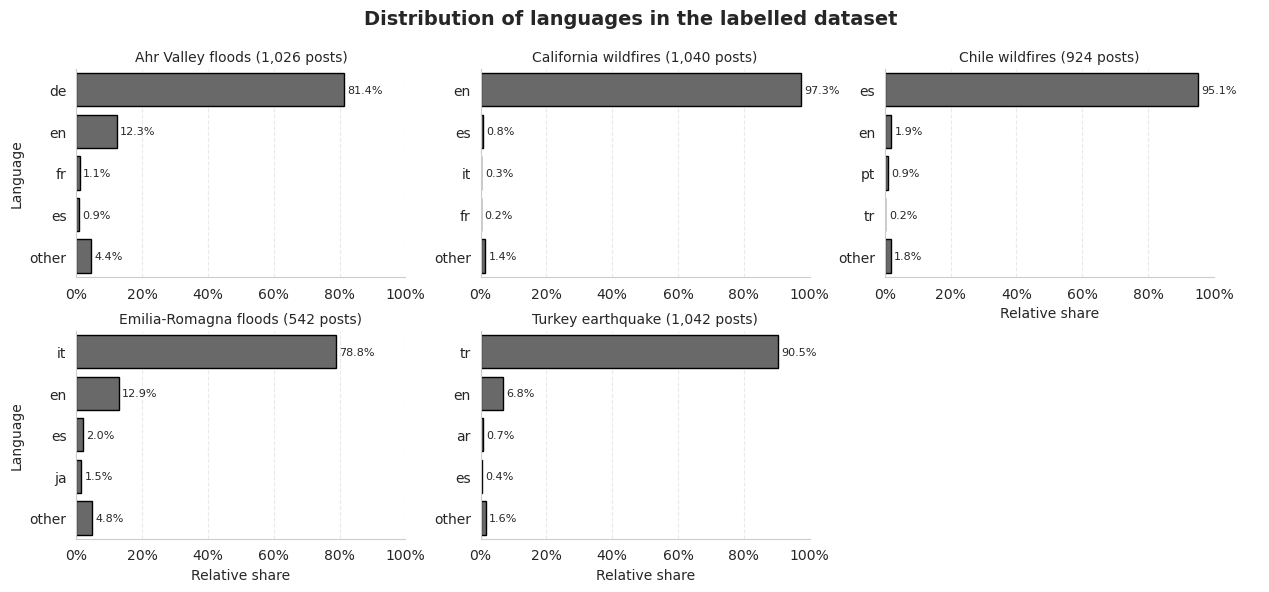

In [88]:
def plot_top_k_langs_by_use_case(df: pd.DataFrame, k: int = 5):
    """
    Plot the top-k language distribution for each use case in a seaborn grid.

    Args:
        df (pd.DataFrame): Input dataframe with 'tweet_lang' and 'use_case' columns.
        k (int): Number of top languages to include (including 'other' if necessary).
    """
    all_data = []
    df = df.copy()

    # map qme to und
    df['tweet_lang'] = df['tweet_lang'].apply(lambda x: 'und' if x in ['qme', 'zxx', 'qht'] else x)

    # map labels to better looking ones
    df['use_case_label'] = df['use_case'].map(use_case_labels)
    use_case_counts = df['use_case_label'].value_counts().to_dict()

    # Append dataset size to label (e.g., 'Earthquake (n = 1234)')
    df['use_case_label_n'] = df['use_case_label'].apply(
        lambda uc: f"{uc} ({use_case_counts[uc]:,} posts)"
    )

    # Compute top-k language distributions for each use case
    for use_case, group in df.groupby('use_case_label_n'):
        top_langs_df = top_k_lang_distribution(group, k)
        top_langs_df['use_case_label_n'] = use_case
        all_data.append(top_langs_df)

    # Combine all into one DataFrame
    plot_df = pd.concat(all_data, ignore_index=True)

    # Set up the seaborn grid
    g = sns.catplot(
        data=plot_df,
        kind="bar",
        y="tweet_lang",
        x="rel_share_pct",
        col="use_case_label_n",
        col_wrap=3,
        sharey=False,
        sharex=False,
        height=3,
        aspect=1.4,
        color='dimgray',
        edgecolor='k',
        linewidth=1
    )

    g.set_axis_labels("Relative share", "Language")
    g.set_titles("{col_name}")
    g.set(xlim=(0, 100))  # Set x-axis limit to 100%
    # g.set_xticklabels(rotation=45)
    g.tight_layout()

    # Add text labels next to bars
    for ax in g.axes.flatten():
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))
        for bar in ax.patches:
            width = bar.get_width()
            y = bar.get_y() + bar.get_height() / 2
            ax.text(
                width + 1,  # a bit to the right of the bar
                y,
                f"{width:.1f}%", 
                va='center',
                ha='left',
                fontsize=8
            )

    # Add a bold suptitle
    plt.subplots_adjust(top=0.88)  # leave space for the suptitle
    plt.suptitle(f'Distribution of languages in the labelled dataset', fontsize=14, fontweight='bold')
    plt.savefig(os.path.join(RESULTS_PATH, 'feature_engineering', 'language_distribution.pdf'), dpi=300, bbox_inches='tight')
    plt.show()

plot_top_k_langs_by_use_case(df=relevance_tweets, k=5)

In [100]:
def print_accuracy_per_language_per_use_case(df: pd.DataFrame):
    """
    Prints classification accuracy per tweet_lang within each use_case.

    Args:
        df (pd.DataFrame): DataFrame containing 'use_case', 'tweet_lang', 'int_label', and 'prediction' columns.
    """
    df = df.copy()
    df['tweet_lang'] = df['text'].apply(detect_language_fast)
    grouped = df.groupby(['use_case', 'tweet_lang'])

    print("Accuracy per language per use case:\n")

    for (use_case, lang), group in grouped:
        total = len(group)
        correct = (group['int_label'] == group['prediction']).sum()
        accuracy = correct / total if total > 0 else 0
        print(f"{use_case} | {lang}: {accuracy:.2%} ({correct}/{total})")

    # macro F1 version
    # for (use_case, lang), group in grouped:
    #     if len(group['int_label'].unique()) > 1 and len(group['prediction'].unique()) > 1:
    #         f1 = f1_score(group['int_label'], group['prediction'], average='macro')
    #         print(f"{use_case} | {lang}: {f1:.3f} (n = {len(group)})")
    #     else:
    #         print(f"{use_case} | {lang}: Insufficient label diversity (n = {len(group)})")

relevance_tweets.loc[
    :, 'tweet_lang'
] = relevance_tweets['text'].apply(lambda x: detect_language_fast(text=x))


print_accuracy_per_language_per_use_case(df=non_text_preds)

Accuracy per language per use case:

California 🔥 | ceb: 100.00% (1/1)
California 🔥 | en: 52.04% (102/196)
California 🔥 | eo: 100.00% (1/1)
California 🔥 | es: 100.00% (2/2)
California 🔥 | it: 0.00% (0/1)
California 🔥 | ko: 0.00% (0/1)
California 🔥 | la: 100.00% (1/1)
California 🔥 | nl: 100.00% (1/1)
Chile 🔥 | en: 100.00% (3/3)
Chile 🔥 | es: 73.83% (110/149)
Chile 🔥 | jbo: 100.00% (1/1)
Chile 🔥 | ms: 100.00% (1/1)
Chile 🔥 | pt: 100.00% (1/1)
Chile 🔥 | sk: 100.00% (1/1)
Chile 🔥 | tr: 100.00% (1/1)
Germany 🌊 | ar: 100.00% (1/1)
Germany 🌊 | cs: 100.00% (1/1)
Germany 🌊 | de: 76.09% (140/184)
Germany 🌊 | en: 88.89% (24/27)
Germany 🌊 | fi: 50.00% (1/2)
Germany 🌊 | fr: 100.00% (3/3)
Germany 🌊 | nl: 100.00% (1/1)
Germany 🌊 | pl: 66.67% (2/3)
Germany 🌊 | tr: 100.00% (2/2)
Italy 🌊 | en: 100.00% (12/12)
Italy 🌊 | es: 80.00% (4/5)
Italy 🌊 | fi: 100.00% (1/1)
Italy 🌊 | it: 72.15% (57/79)
Italy 🌊 | ja: 50.00% (1/2)
Italy 🌊 | ru: 0.00% (0/1)
Turkey 🪨 | ar: 100.00% (2/2)
Turkey 🪨 | az: 100.00% (1/1)
Tu

In [96]:
def print_accuracy_per_language(df: pd.DataFrame):
    """
    Prints classification accuracy per tweet_lang.

    Args:
        df (pd.DataFrame): DataFrame containing 'tweet_lang', 'int_label', and 'prediction' columns.
    """
    df = df.copy()
    df['tweet_lang'] = df['text'].apply(detect_language_fast)
    grouped = df.groupby('tweet_lang')

    print("Accuracy per language per use case:\n")

    for lang, group in grouped:
        total = len(group)
        correct = (group['int_label'] == group['prediction']).sum()
        accuracy = correct / total if total > 0 else 0
        print(f"{lang}: {accuracy:.2%} ({correct}/{total})")

    # macro F1 version
    # for (use_case, lang), group in grouped:
    #     if len(group['int_label'].unique()) > 1 and len(group['prediction'].unique()) > 1:
    #         f1 = f1_score(group['int_label'], group['prediction'], average='macro')
    #         print(f"{use_case} | {lang}: {f1:.3f} (n = {len(group)})")
    #     else:
    #         print(f"{use_case} | {lang}: Insufficient label diversity (n = {len(group)})")

print_accuracy_per_language(df=joint_preds)

Accuracy per language per use case:

ar: 66.67% (2/3)
az: 100.00% (1/1)
ceb: 100.00% (1/1)
cs: 100.00% (1/1)
de: 86.96% (160/184)
el: 100.00% (1/1)
en: 75.20% (185/246)
eo: 100.00% (1/1)
es: 85.26% (133/156)
et: 100.00% (1/1)
fi: 100.00% (3/3)
fr: 100.00% (4/4)
hr: 100.00% (1/1)
it: 86.25% (69/80)
ja: 100.00% (2/2)
jbo: 100.00% (1/1)
ko: 100.00% (1/1)
la: 100.00% (1/1)
ms: 100.00% (1/1)
nl: 50.00% (1/2)
pl: 66.67% (2/3)
pt: 100.00% (1/1)
ru: 0.00% (0/1)
sk: 100.00% (1/1)
tr: 85.78% (187/218)


## 9. Labelled examples
Lastly, let's plot some labelled examples in a table for the reviewers.

In [12]:
train_gdf: gpd.GeoDataFrame = gpd.read_parquet(os.path.join(DATA_PATH, 'processed', 'fine_tuning', 'train_data.parquet'))
print(train_gdf.shape)
train_gdf['use_case_label'] = train_gdf['use_case'].map(use_case_labels)
train_gdf[['use_case_label', 'text', 'date', 'geometry', 'human_label_100km']]

(3659, 45)


,use_case_label,text,date,geometry,human_label_100km
0,California wildfires,Closed due to the czu august lightning complex...,2020-08-21 13:40:45,POINT (-122.36110 37.16663),Related but not relevant
1,Ahr Valley floods,Mich beunruhigt nichts mehr.Wir sorgen persönl...,2021-07-19 12:23:18,POINT (12.22671 51.84923),Related but not relevant
2,California wildfires,The view out my kitchen window of the massive ...,2020-12-22 06:29:24,POINT (-118.41191 34.02069),Related and relevant
3,California wildfires,@user @user @user I love 1/2 miles from Anahei...,2020-10-26 22:49:26,POINT (-117.85109 33.84275),Related and relevant
4,California wildfires,Someone fucking set off my apartment building’...,2020-08-19 11:26:50,POINT (-118.41191 34.02069),Not related
...,...,...,...,...,...
3654,Turkey earthquake,Hatay/Hassa'da en kazın altında çıkan not...#d...,2023-02-12 06:18:19,POINT (36.51252 36.78301),Related and relevant
3655,Turkey earthquake,FutBol Sohbet programımızın yeni bölümü YouTub...,2023-01-03 15:19:57,POINT (33.78141 41.38023),Not related
3656,Chile wildfires,Pasando ahora 😭😭 #Coronel #Biobio #IncendioFor...,2023-02-19 02:12:45,POINT (-73.22220 -37.00482),Related and relevant
3657,Ahr Valley floods,Rhein unterspült Uferstrasse in Basel und löst...,2021-07-16 21:10:24,POINT (7.65276 47.57676),Related but not relevant


In [22]:
# Select one example per (use_case_label, human_label_100km) group
sample_df: pd.DataFrame = (
    train_gdf
    .sort_values('date')  # or use random sampling: .sample(1)
    .groupby(['use_case_label', 'human_label_100km'])
    .sample(1, random_state=41)
    .reset_index(drop=True)
)
sample_df['geometry_str'] = sample_df['geometry'].apply(lambda geom: geom.wkt)
sample_df['geometry_str'] = sample_df['geometry_str'].str.replace(r'(\d+\.\d{2})\d*', r'\1', regex=True)

print(sample_df[['use_case_label', 'text', 'date', 'geometry_str', 'human_label_100km']].to_latex(index=False))

\begin{tabular}{lllll}
\toprule
use_case_label & text & date & geometry_str & human_label_100km \\
\midrule
Ahr Valley floods & @user Da muss ich mal mit :) & 2021-07-31 18:14:15 & POINT (7.04 50.74) & Not related \\
Ahr Valley floods & Bilder von heute aus Bad Neuenahr. Freunde haben alles, wirklich alles verloren. Sie hatten Glück und haben sich aufs Dach retten können. Werde die Tage nochmal hinfahren und schauen was ich tun kann. Erstmal muss das Haus aber trocken werden. #Unwetterkatastrophe #BadNeuenahr http & 2021-07-19 17:40:22 & POINT (7.58 50.34) & Related and relevant \\
Ahr Valley floods & via @user: Helfende Hände aus Unterfranken in Rheinland-Pfalz und NRW im Einsatz in den Hochwassergebieten 🙏👏👏👏http & 2021-07-19 16:11:02 & POINT (9.93 49.77) & Related but not relevant \\
California wildfires & @user Lol never & 2020-08-01 03:19:06 & POINT (-118.41 34.02) & Not related \\
California wildfires & I live in California.  There are fires everywhere and I can't breath. Should 